# FIT5196 Assessment 4 - Data Integration & Data Reshaping

###  Group 103:

##### Student Name: Alan Gewerc
##### Student ID: 29961246
##### Student Name: Cristiana Garcia Gewerc
##### Student ID: 30088887


Date: 27/10/2019

Environment: Python 3.7.1 and Jupyter Notebook 5.7.4 (64-bit)

Libraries used:
* bs4 (for function BeatifulSoup)
* difflib (for sequence matching and similarity checking)
* geopandas 0.6.1 (for shapefiles, not included in Anaconda 3.7.1)
* math (for mathematical functions)
* matplotlib.pyplot (for visualisations)
* numpy 1.15.4 (for array-like operations)
* pandas 0.23.4 (for data frame) 
* statistics (function mean)
* statsmodels.formula.api (function smf)
* urllib.request (for webscraping with function urlopen)
* xml.etree.ElementTree (for parsing XML doc)
* zipfile (functions ZipFile, shutil)

# 1. Introduction

This assignment comprises the execution of different data integration, data reshaping and analysis tasks applied to Real Estate data located in Victoria in CSV format. There are a total of 720 properties in one file of 64 KB: <br>
`real-estate.csv`: In this file, we have data regarding the adress, price, number of rooms, latitude and longitude and more. We want to integrate in this file more information related to access of public transporatation, proximity of schools and criminal activity in the region. In adittion, we want to examinate if there is a linear relationship between some of the variables and the price of the property. To execute this tasks we will count with a set of support files such as:<br>
`gtfs:` A set of files that defines a common format for public transportation schedules and associated geographic information. In this case, a folder containing detailed information about public transportation in the state of Victoria, such as all stop stations of all kinds of transports, every trip, every route, etc.<br>
`vic_suburb_boundary.zip:` A folder containing shapefiles with geografic information about the state of Victoria, that identifies graphically and spatially all the suburbs of Victoria.<br>
`crimebylocationdatatable-yearending31march2016:` A complete dataset with crime information by region.<br>
`councils.txt`: A text file mapping local government areas with it's suburbs <br>
`schools.xml`: A XML file containing information about schools, such as their names, latitude, longitude and type.
 
The required tasks are the following:<br>

1. Identify the the closest train station (regional/metropolitan) that has a direct trip to the "Southern Cross Railway Station" on weekdays departing between 7 to 9:30 am, calculate its distance to the property and also the average price of the trip, from the station to Southern Cross. 
2. Identify if the the property is higher than the median price of similar properties in the same suburb on the year of selling.
3. Calculate the average of crimes type A, B and C in the local government area the property belongs to, in the three years prior to selling the property as the property. 
4. Find the closest primary and secondary schools to the property, their distance, and how they are ranked among all scholls.
5. Study the effect of different normalization/transformation methods on some attributes assuming that we want to build a linear model on price using these attributes as predictors.


# 2. Data Integration

This part comprises most of the tasks of this assignment, more specifficaly tasks 1 to 4 mentioned above. As we have explained, in the file `real-estate.csv` there is a dataset with data of 720 properties and we will use the others datasets to integrate valuable data in this file. After importing the relevant libraries and loading the files, we will start with this integration activities.



## 2.1. Import Libraries

In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import math
from urllib.request import urlopen
from bs4 import BeautifulSoup
import difflib
from zipfile import ZipFile, shutil
from statistics import mean
import statsmodels.formula.api as smf

## 2.2. Load the Files

First, we load the files that where provided to us and will be used over this assignment. Some data comes already ready-to-use and other will required further wrangling work when it comes to the moment where they are required.

The webscraping for school rankings and the GTFS data will be read and deal with only when we need them. All other datasets will be treated and load into dataframes here.

### 2.2.1. real-estate.csv
Load into pandas with `pd.read_csv()`:

In [2]:
data_103 = pd.read_csv('data/real-estate.csv')
data_103.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID785374174,3 Valnere St,4,h,940000.0,7/05/2016,2.0,1.0,516.0,34.0,-37.78390,144.88530
1,ID469398047,16 Scotia St,3,h,1325000.0,10/12/2016,2.0,1.0,97.0,8.0,-37.80140,144.94900
2,ID532121713,16 Sylvan St,4,t,1680000.0,18/03/2017,3.0,1.0,362.0,5.0,-37.79870,145.07880
3,ID727598171,195 Blackshaws Rd,3,h,975000.0,13/05/2017,2.0,2.0,333.0,9.0,-37.83340,144.86730
4,ID967462022,40 Lockton Av,3,h,670000.0,29/07/2017,2.0,1.0,536.0,49.0,-37.69505,144.98126


### 2.2.2. Crimebylocation.xlsx
Load into pandas with `pd.read_excel()`. Opening the file with excel previously, we were able to see that the data we are interested on is located in sheet `Table 1` and the table begins at row 19. The first column is blank and there are 9 columns. The first ros contains the headers. We can inform pandas about all of that and get the proper output:

In [3]:
data_crime = pd.read_excel('crimebylocationdatatable-yearending31march2016.xlsx', 
                      sheet_name='Table 1', skiprows=list(range(19)), usecols=list(range(1,12)))
data_crime.head()

,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
0,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
2,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
3,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
4,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521


### 2.2.3 vic_suburb_boundary

We will use geopandas to load the shapefile and further work/explain it when analysing the `Suburbs`.

In [4]:
data_boundary = gpd.read_file('vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp')
type(data_boundary)

geopandas.geodataframe.GeoDataFrame

### 2.2.4. schools.xml

We use [ElementTree](https://docs.python.org/3/library/xml.etree.elementtree.html) (Python Software Foundation, 2019a) to parse the XML file and get the attributes that we want, given their relative positions in the xml, which were found after analysing the file structure (`School_Name` in relative in position 3 from the root, `School_Type` in relative in position 4 from the root, `X` relative in position 13 from the root that is the latitude and `Y` in relative in position 14 from the root that is the longitude). We will base our approach in this [medium article](https://medium.com/@robertopreste/from-xml-to-pandas-dataframes-9292980b1c1c) (Preste, 2019), transforming the xml in a pandas' dataframe called `data_school`.

In [5]:
school_cols = ['school_name', 'school_type', 'school_lat', 'school_long']
school_rows = []
# using element tree to parse the xml
root = ET.parse('schools.xml').getroot()
for child in root:
    s_name = child[3].text
    s_type = child[4].text
    s_longitude = float(child[13].text)
    s_latitude = float(child[14].text)
    # we append the parsed information to be further used in our dataframe as rows
    school_rows.append({'school_name': s_name, 'school_type' : s_type, 
                         'school_lat': s_latitude, 'school_long' : s_longitude})
# after retrieving all information about school names, types, latitude and longitude, we organize it in a dataframe
data_school = pd.DataFrame(school_rows, columns = school_cols)

# checking output:
data_school.head()

,school_name,school_type,school_lat,school_long
0,Alberton Primary School,Primary,-38.617713,146.666601
1,Allansford and District Primary School,Primary,-38.386281,142.590393
2,Avoca Primary School,Primary,-37.084502,143.475649
3,Avenel Primary School,Primary,-36.901368,145.234722
4,Warrandyte Primary School,Primary,-37.742675,145.213980


### 2.2.5. data_council

It's a 'txt' file with a `:` as a separator between one string and a list of strings per row. We can load it into pandas as a csv, just informing pandas what is the separator. Further work on `data_council` dataframe will be done when analysing crimes.

In [6]:
data_council = pd.read_csv('data/councils.txt', sep = ":", header=None)
data_council.head()

,0,1
0,BANYULE,"['Abbotsford', 'Airport West', 'Albert Park',..."
1,BRIMBANK,"['Altona', 'Altona North', 'Armadale', 'Ascot..."
2,DAREBIN,"['Ashburton', 'Ashwood', 'Avondale Heights', ..."
3,HOBSONS BAY,"['Balwyn', 'Balwyn North', 'Bentleigh', 'Bent..."
4,HUME,"['Box Hill', 'Braybrook', 'Brighton', 'Bright..."


## 2.3. Generate the Dataset

The `data_solution` dataframe file must contain the following columns:


1. `ID`: A unique id for the property (already in `data_103`)
2. `Address`: The property address (already in `data_103`)
3. `Suburb`: The property suburb. The suburb must only be calculated using `Vic_suburb_boundary.zip` (data_boundary). Default value: “not available”
4. `Price`: The property price (already in `data_103`)
5. `Type`: The type of property (already in `data_103`)
6. `Date`: Date of sold (already in `data_103`)
7. `Rooms`: Number of bedrooms (already in `data_103`)
8. `Bathroom`: Number of bathrooms (already in `data_103`)
9. `Car`: The number of parking space of the property (already in `data_103`)
10. `LandSize`: The area of the property (already in `data_103`)
11. `Age`: The age of the property at the time of selling (already in `data_103`)
12. `Latitude`: The Latitude of the property (already in `data_103`)
13. `Longitude`: The Longitude of the property (already in `data_103`)
14. `train_station_id`: The closest train station to the property that has a direct trip to the Southern Cross Railway Station. A direct trip is a trip where there are no connections (transfers) in the trip from the origin to the destination. Default value: -1
15. `distance_to_train_station`: The direct distance from the closest train station (identified above) to the property. Default value: -1
16. `travel_min_to_CBD`: The average travel time (minutes) from the closest train station (regional/metropolitan) that has a direct trip to the “Southern Cross Railway Station” on weekdays (i.e. Monday-Friday) departing between 7 to 9:30 am. For example, if there are 3 direct trips departing from the closest train station to the Southern Cross Railway Station on weekdays between 7-9:30 am and each takes 6, 7, and 8 minutes respectively, then the value of this column for the property should be (6+7+8)/3.). Default value: -1
17. `over_priced?`: A boolean feature indicating whether or not the price of the property is higher than the median price of similar properties (with respect to bedrooms, bathrooms, parking_space, and property_type attributes) in the same suburb on the year of selling. Default value: -1
18. `crime_A_average`: The average of type A crime in the local government area the property belongs to, in the three years prior to selling the property as the property. For example, if a property is sold in 2016, then you should calculate the average of the crime type A for 2013, 2014 and 2015. Default value: -1
19. `crime_B_average`: The average of type B crime in the local government area the property belongs to, in the three years prior to selling the property as the property. For example, if a property is sold in 2016, then you should calculate the average of the crime type B for 2013, 2014 and 2015. Default value: -1
20. `crime_C_average`: The average of type C crime in the local government area the property belongs to, in the three years prior to selling the property as the property. For example, if a property is sold in 2016, then you should calculate the average of the crime type C for 2013, 2014 and 2015. Default value: -1
21. `closest_primary_school`: The name of the closest primary school to the property. Default value: “not available”
22. `distance_to_closest_primary`: The direct distance between the property and the closest primary school. Default value: -1
23. `primary_school_ranking`: The ranking of the closest primary school to the property as scraped from http://www.schoolcatchment.com.au/?p=12301 If the school is not listed, the value of this field should be set to “not ranked”. Default value: -1
24. `closest_secondary_school`: The name of the closest secondary school to the property. Default value: “not available”
25. `distance_to_closest_secondary`: The direct distance between the property and the closest secondary school. Default value: -1
26. `secondary_school_ranking`: The ranking of the closest secondary school to the property as scraped from https://sites.google.com/a/monash.edu/secondary-school-ranking/ If the school is not listed, the value of this field should be set to “not ranked”. Default value: -1

In [7]:
# creating data_solution initially with all columns in data_103
data_solution = data_103
# having a look:
data_solution.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID785374174,3 Valnere St,4,h,940000.0,7/05/2016,2.0,1.0,516.0,34.0,-37.78390,144.88530
1,ID469398047,16 Scotia St,3,h,1325000.0,10/12/2016,2.0,1.0,97.0,8.0,-37.80140,144.94900
2,ID532121713,16 Sylvan St,4,t,1680000.0,18/03/2017,3.0,1.0,362.0,5.0,-37.79870,145.07880
3,ID727598171,195 Blackshaws Rd,3,h,975000.0,13/05/2017,2.0,2.0,333.0,9.0,-37.83340,144.86730
4,ID967462022,40 Lockton Av,3,h,670000.0,29/07/2017,2.0,1.0,536.0,49.0,-37.69505,144.98126


Before starting, I'll fix the `Latitude` column name that came with one extra `t` and `Longitude` that is also misspelled.

In [8]:
data_solution.rename(columns={'Lattitude':'Latitude', 'Longtitude':'Longitude'}, inplace=True)

### 2.3.1 Suburb

We will use the `data_boundary` dataframe, obtained in the shapefile contained in`Vic_suburb_boundary.zip`. 

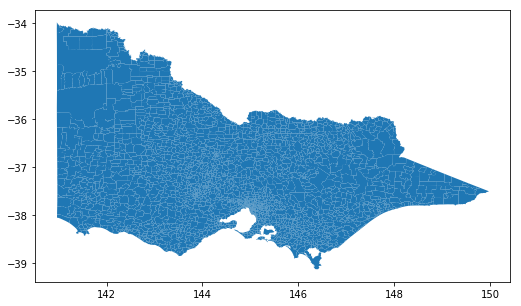

In [9]:
data_boundary.plot(figsize=(10,5))

In [10]:
data_boundary.head(2)

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552399 -35.07228701, 141.74552..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.668767 -37.39571245, 148.6687620..."


We have the boundaries of each suburb of Melbourn in the `data_boundary` dataframe. We need a function able to identify in which suburb a given latitude/longitude pair is within. Following the approach described in this [article](https://medium.com/dataexplorations/working-with-open-data-shape-files-using-geopandas-how-to-match-up-your-data-with-the-areas-9377471e49f2) (Gordon, 2018). First, we define a function to identify if the lat/long pair is inside the polygon and a function to match the coordinates to neighbourhoods:

In [11]:
#returns true if lat/long are within the bounds of the polygon
#poly: a list of lat/long coordinates that define the boundary of an area
def point_inside_polygon(lat,lng,poly):
    n = len(poly)
    inside =False
    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if lat > min(p1y,p2y):
            if lat <= max(p1y,p2y):
                if lng <= max(p1x,p2x):
                    if p1y != p2y:
                        xinters = (lat-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or lng <= xinters:
                        inside = not inside
        p1x,p1y = p2x,p2y
    return inside

# return neighbourhood name of the one where the row's latitude and longitude is inside
def get_neighbourhood(row):
    for ix, area in data_boundary.iterrows():
        is_in_area=False
        if row['Latitude'] and row['Longitude']:
            is_in_area = point_inside_polygon(row['Latitude'], row['Longitude'], area['geomlist'])
            if is_in_area:
                #found area, exit
                return area['VIC_LOCA_2']
    return 'not available'

To apply the function, we need a list of tuple pairs with the exterior coordinates of each area. This can be easily obtained from the `geometry`:

In [12]:
# geometry column is of type shapely.coords.CoordinateSequence, 
# so executing exterior.coords will return the exterior coordinates as a list
data_boundary['geomlist'] = data_boundary['geometry'].apply(lambda x: list(x.exterior.coords))

Finally, we can apply the`get_neighbourhood()` function to find our the neighbourhood for all the rows in our `data_solution` dataframe.

In [13]:
data_solution['Suburb'] = data_solution.apply(lambda row: get_neighbourhood(row), axis=1)

Let's check the results:

In [14]:
data_solution.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Latitude,Longitude,Suburb
0,ID785374174,3 Valnere St,4,h,940000.0,7/05/2016,2.0,1.0,516.0,34.0,-37.78390,144.88530,MARIBYRNONG
1,ID469398047,16 Scotia St,3,h,1325000.0,10/12/2016,2.0,1.0,97.0,8.0,-37.80140,144.94900,NORTH MELBOURNE
2,ID532121713,16 Sylvan St,4,t,1680000.0,18/03/2017,3.0,1.0,362.0,5.0,-37.79870,145.07880,BALWYN NORTH
3,ID727598171,195 Blackshaws Rd,3,h,975000.0,13/05/2017,2.0,2.0,333.0,9.0,-37.83340,144.86730,NEWPORT
4,ID967462022,40 Lockton Av,3,h,670000.0,29/07/2017,2.0,1.0,536.0,49.0,-37.69505,144.98126,RESERVOIR


### 2.3.2 - Train Stations

Now we will work on GTFS data.<br>
This [link](https://www.researchgate.net/figure/The-GTFS-Schema-for-the-data-from-JSP-Skopje_fig1_263853949) gives us valuable insight about the GTFS schema, presentind the database structure that we are working with and how each file is related to one another. Most likely we won't use all files because we are not been questioned about agencies, routes etc. From the perspective of the Real State owner, it is important to know the closest train station, how far away it is and related facts. <br> 
In addition, we want transportation related to regional/metropolitan trains, so not all folders from the GTFS data are relevant. Actually, only folders one and two will do the job. This [document](http://data.ptv.vic.gov.au/downloads/PTVGTFSReleaseNotes.pdf) from PTV - the Transportation Company of the State of victoria,  explains that each folder number is associetaded with a transportation type. While folder one is for regional trains and folder two for metropolitan trains, all other folders refer to other kinds of transportation. For instance, folder 11 refers to skybus, the one that connects the city to the aiports. <br><br>
In this part, we want to find:<br>
1. The closest train station to the property that has a direct trip to the Southern Cross Railway Station.<br>
2. The direct distance from the closest train station (identified above) to the property.<br>
3. The average travel time (minutes) from the closest train<br>
station (regional/metropolitan) that has a direct trip to the `Southern Cross Railway Station` on weekdays departing between 7. to 9:30 am.<br>


To start, we will: <br>
1. Unzip the folder `gtfs`
2. Delete folders from 3 to 11
3. Unzip the folders `google-transit` of folders 1 and 2

In [15]:
# Unzipping gfts
zip_gtfs = ZipFile('gtfs.zip')
zip_gtfs.extractall()
zip_gtfs.close()

# removing files
rm_file_list = [3,4,5,6,7,8,10,11] # these are the names of the folders that will be deleted
for i in rm_file_list:
    shutil.rmtree(str(i))

# Unzipping gfts
zip1 = ZipFile('1\google_transit.zip')
zip1.extractall(path = '1')
zip2 = ZipFile('2\google_transit.zip')
zip2.extractall(path = '2')

After extracting all the relevant data (and deleting the irrelevant) we will start to import the relevant tables, which are the following:<br>
1 - `trips:` Contains a list of all the trips in victoria.<br>
2 - `stops:` Constains a list of all stop stations (we want only trains related).<br>
3 - `stop_times:` is a bridge entity (database language) between trips and stops. Contains all stops by trips.<br>
4 - `Calendar:` We will use it to know what services works in each day of the week - we will filter trips that work everyweekday.<br>
We will import files from folder 1 and 2, and further concatenate the tables. 

 

In [16]:
trips1 = pd.read_csv('data/1/trips.txt', sep=",")
stops1 = pd.read_csv('data/1/stops.txt', sep=",")
stop_times1 = pd.read_csv('data/1/stop_times.txt', sep=",")
calendar1 = pd.read_csv('data/1/calendar.txt', sep=",")

trips2 = pd.read_csv('data/2/trips.txt', sep=",")
stops2 = pd.read_csv('data/2/stops.txt', sep=",")
stop_times2 = pd.read_csv('data/2/stop_times.txt', sep=",")
calendar2 = pd.read_csv('data/1/calendar.txt', sep=",")

We have imported the tables, now we must merge and concatenate them. As we have demonstrated, the structure of gtfs is a database schema, and tables have primary keys, foreign keys, etc. We will use columns `stop_id`, `trip_id` to unite the tables 1, 2 and 3 and generate a complete dataframe with all relevant data that we may need. We will also merge those that refer to folder 1 and folder 2. 

In [17]:
# merging different tables from same folder
df_trips1 = pd.merge(trips1, pd.merge(stop_times1, stops1, on='stop_id', how='left'), on='trip_id', how='right') 
df_trips2 =  pd.merge(trips2, pd.merge(stop_times2, stops2, on='stop_id', how='left'), on='trip_id', how='right')

# concatenating  tables from different folders
df_trips = pd.concat([df_trips1, df_trips2], axis=0)
calendar = pd.concat([calendar1, calendar2], axis=0) 
df_trips.shape

(541977, 17)

Now we have built a huge a complete dataset, but most likely not all columns are need. To make visualization and coding easier we will filter our dataframe columns. To find the closest station to each property and related matters, the only columns that we need are the following:<br>

`service_id:` The type of service - related to calendar identifies dates that the service is offered .<br>
`trip_id:` The unique identifier of every trip.<br>
`arrival_time:` The arrival time of each stop of every trip.<br>
`departure_time:` The departure time of each stop of every trip.<br>
`stop_id:` The departure time of each stop of every trip. <br>
`stop_sequence:` The sequential number of a stop in trip. <br>
`stop_name:` The name of every stop.<br>
`stop_lat:` The latitude of every stop. <br>
`stop_lon:` The longitutede of every stop. <br>

In [18]:
df_trips = df_trips.loc[:, ['service_id', 'trip_id', 'arrival_time', 'departure_time', 
                            'stop_id','stop_sequence', 'stop_name', 'stop_lat', 'stop_lon']]
df_trips.head()

,service_id,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon
0,T0,1051.T0.1-V08-G-mjp-1.1.H,06:08:00,06:08:00,20291,1,Bairnsdale Railway Station (Bairnsdale),-37.828720,147.627614
1,T0,1051.T0.1-V08-G-mjp-1.1.H,06:42:00,06:42:00,20346,2,Stratford Railway Station (Stratford),-37.967047,147.081469
2,T0,1051.T0.1-V08-G-mjp-1.1.H,06:55:00,06:57:00,20341,3,Sale Railway Station (Sale),-38.103103,147.054805
3,T0,1051.T0.1-V08-G-mjp-1.1.H,07:16:00,07:16:00,20339,4,Rosedale Railway Station (Rosedale),-38.156404,146.786966
4,T0,1051.T0.1-V08-G-mjp-1.1.H,07:32:00,07:34:00,20351,5,Traralgon Railway Station (Traralgon),-38.198885,146.537882


Our next step is to create a filter using the calendar dataframe. The [calendar](https://developers.google.com/transit/gtfs/reference#calendartxt) dataframe holds information about the days that every service type is offered. We will identify by service_id those that work every weeday, because in each column they will be marked as 1 if they work regularly (and 0 if they don't).

In [19]:
calendar.head()

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,UR,0,0,0,1,0,0,0,20190509,20190509
1,T6,0,0,0,0,1,0,0,20190510,20190510
2,T2,0,0,0,0,0,1,0,20190511,20190511
3,UJ,0,0,0,0,0,0,1,20190512,20190512
4,UO,1,0,0,0,0,0,0,20190513,20190513


We are creating a set that has every service_id that has **1** marked from monday to friday.

In [20]:
df_services = calendar[(calendar['monday'] == 1) & (calendar['tuesday'] == 1) & 
                    (calendar['wednesday'] == 1) & (calendar['thursday'] == 1) & 
                    (calendar['friday'] == 1)]

services_set = set(df_services['service_id'])

print("list of services:", services_set)


list of services: {'T0_1', 'T0_2', 'T0_3', 'T0'}


This are the services that in which we are interested. All other *service_ids* we will filter away from our big dataframe.

In [21]:
print('Number of rows before service_id filter:', len(df_trips))
df_trips = df_trips[(df_trips['service_id'] == 'T0') | (df_trips['service_id'] == 'T0_1') | 
                    (df_trips['service_id'] == 'T0_2') | (df_trips['service_id'] == 'T0_3')]
print('Number of rows after service_id filter:', len(df_trips))

Number of rows before service_id filter: 541977
Number of rows after service_id filter: 60159


Our filter was successful and a very large part of the rows was filtered. As we can see, most services do not work everyday of the week. <br><br>

Now we wil proceed with another very important filter. As asked, we want only trips that have as `departure_time` the range between 7 A.M and 9:30 A.M. We will remove from our dataset every row that is not in this range of time.<br>
**One important exception - we wont remove** `Southern Cross Station`, no matter what is the time. This is because we are filtering departures and *Southern Cross* is our destination. But first we must do some manipulations with the departure and arrival time variables. Lests see what is the data type of this columns:

In [22]:
df_trips.dtypes

service_id         object
trip_id            object
arrival_time       object
departure_time     object
stop_id             int64
stop_sequence       int64
stop_name          object
stop_lat          float64
stop_lon          float64
dtype: object

The type is object, quite similar to string. There are two possibilities for us to continue, transform this columns to time variables or numeric. For personal choice, we have decided to proceed with the second option and transform in numbers. We will use the following approach:<br>
`Hours* 60 + minutes` <br>
This will return the number of minutes that have passed on the day, starting from 0 A.M.<br>
We will use *apply with lambda functions* to make this conversion and store the result in new columns: `departure_numeric_time` and `arrival_numeric_time`. 


In [23]:
df_trips['departure_numeric_time'] = df_trips['departure_time'].apply(lambda x: int(x[0:2])*60 + int(x[3:5]))
df_trips['arrival_numeric_time'] = df_trips['arrival_time'].apply(lambda x: int(x[0:2])*60 + int(x[3:5]))

Now we will do the filtering, using this recently created columns. we are also creating variables to represent the timeof the day: **early_range and later_range**.

In [24]:
print('Number of rows before departure_time filter:', len(df_trips))

early_range = 7*60
later_range = 9*60+30

df_trips = df_trips[((df_trips['departure_numeric_time'] >= early_range) & (df_trips['departure_numeric_time'] <= later_range)) |
                     (df_trips['stop_name'] == 'Southern Cross Railway Station (Melbourne City)')]

print('Number of rows before departure_time filter:', len(df_trips))

Number of rows before departure_time filter: 60159
Number of rows before departure_time filter: 13661


Again, our filter was successful and a significant part of the rows was filtered. We consider the number of rows filtered as proportional. Out of 60159 departures from trips, 13661 are between 7 and 9:30 AM (+ those those that have southern cross no matter the time).

We have arrived in a crutial task of this part. We must filter all trips that don't have Southern Cross as one of the stops. Actually, the stop_name of the station is `Southern Cross Railway Station (Melbourne City)`. But, as we are working with the database, it is more correct for us to use the stop_id. To continue, we will identify which is the stop_id from this station.

In [25]:
south_list = set(df_trips[df_trips['stop_name'] == 'Southern Cross Railway Station (Melbourne City)'].loc[:,'stop_id'])
print('stop_ids from Southern Cross:', south_list)

stop_ids from Southern Cross: {20043, 22180}


In [26]:
stop_id_south1 = 20043 
stop_id_south2 = 22180

It is unexpected, but we have found two stations for Southern Cross. This is the case because Southern Cross makes the connection between regional and metropolitan trains. We have created variables to refer to which of this stop_ids, as they will be very useful from now on. <br>
Now we will again make filtering, eliminating all trips that don't have stop_ids of southern cross.

In [27]:
print('Number of rows before stop_name filter:', len(df_trips))

# create a set with all trips in the dataframe 
set_trips = set(df_trips['trip_id'])

for trip in set_trips: # iterate over the every trip
    
    # using an auxiliar dataframe to filter the trip
    df_trips_aux = df_trips[df_trips['trip_id'] == trip]
    
    if stop_id_south1 not in list(df_trips_aux['stop_id']) and stop_id_south2 not in list(df_trips_aux['stop_id']):
        
        df_trips = df_trips[df_trips['trip_id'] != trip] 

print('Number of rows before stop_name filter:', len(df_trips))

Number of rows before stop_name filter: 13661
Number of rows before stop_name filter: 11136


As we can see, most trips are connected to Southern Cross, and we agree with this result as we know that the trin structure in Melbourne is 100% focused on the CBD stations, and this is the most important one. <br> 
However, we are not there yet, some additional filtering must be done. <br>
In some trips, `Southern Cross` is a station, but not the last one. A direct trip, means the station should come before `Southern Cross` and not after. So our last filter in this dataframe will eliminate all stop_ids from trips that come after   southern cross.  <br>
This task is a little tricky, as we must do it carefully not to exclude any row that should remain. Our first step will be to sort the dataframe by `trip_id` and `stop_sequence`, as we want it to be organized logically.


In [28]:
df_trips = df_trips.sort_values(['trip_id','stop_sequence']) # make sure the table is in the proper order 

Now the dataframe is ready to be filtered. Here is our logic: <br>
- The dataframe is organized by trip by stop sequence - that means every next stop is the next row or another trip. <br>
- If the last row was Southern Cross and the trip has not changed, this row should be eliminated.<br>
- If the last row should be eliminated and the trip has not changed, again this row should be eliminated.<br>
To apply this logic, we will label all rows that should be eliminated with the string **exclude** where we previously had the stop_id.


In [29]:
# getting the number of the columns we will work on
stop_id = df_trips.columns.get_loc('stop_id')
trip_id = df_trips.columns.get_loc('trip_id')

for i in range(1, len(df_trips)):
    
    if df_trips.iloc[i-1, stop_id] == stop_id_south1 or df_trips.iloc[i-1, stop_id] == stop_id_south2 or df_trips.iloc[i-1, stop_id] == 'exclude':
        
        if df_trips.iloc[i-1, trip_id] == df_trips.iloc[i, trip_id]:
            
            df_trips.iloc[i, stop_id] = 'exclude' 

The labelling was done, now we will filter away all those rows that have the label **exclude** on stop_id.

In [30]:
print('Number of rows before filter - after southern:', len(df_trips))
df_trips = df_trips[df_trips['stop_id'] != 'exclude'] 
print('Number of rows after filter - after southern:', len(df_trips))

Number of rows before filter - after southern: 11136
Number of rows after filter - after southern: 7562


A big fraction of rows was filtered. Behind this there is the fact, that actually `Southern Cross` is the first station for many trips. So all the stations were filtered and this is correct. To finalize we will filter the remaining rows of `Southern Cross`  in trips where it is the first stop. 

In [31]:
print('Number of rows before filter - southern cross as first station:', len(df_trips))
df_trips = df_trips[~((df_trips['stop_name'] == 'Southern Cross Railway Station (Melbourne City)') & 
                      (df_trips['stop_sequence'] == 1))] 
print('Number of rows after filter -  southern cross as first station:', len(df_trips))

Number of rows before filter - southern cross as first station: 7562
Number of rows after filter -  southern cross as first station: 6806


We have arrived at the end of our filtering process. All the stops in the dataframe have direct trips to `Southern Cross Railway Station (Melbourne City)`, everyday of the week, between 7 A.M and 9:30 A.M!<br>
Lets see how many unique stop_ids we have:  

In [32]:
print('There are', len(df_trips['stop_id'].unique()), 'unique remaining stops')

There are 287 unique remaining stops


In [33]:
df_trips['stop_id'].unique()

array([22180, 20339, 20351, 20330, 20328, 20357, 20308, 20313, 22252,
       22250, 20043, 22240, 20325, 20315, 20337, 20303, 22244, 20320,
       20361, 19998, 47642, 20296, 20317, 20301, 20326, 19960, 19961,
       19962, 19963, 19964, 19965, 19966, 19967, 19968, 19969, 19970,
       19971, 19972, 19973, 19841, 19842, 19843, 19854, 20292, 20290,
       22241, 43469, 20293, 19982, 20020, 19980, 19981, 52011, 22248,
       20310, 20338, 20311, 44817, 20030, 20031, 20032, 20033, 20034,
       20035, 20036, 20037, 20038, 20039, 20040, 20041, 40221, 40220,
       15351, 15353, 20000, 20001, 20002, 20003, 20004, 20021, 20025,
       20022, 20023, 20024, 17204, 20307, 22254, 22253, 22239, 20332,
       20342, 20298, 20319, 20355, 19926, 19927, 19994, 19995, 19996,
       19997, 19923, 19925, 19991, 19992, 19993, 20026, 46468, 19924,
       19921, 19922, 20318, 20336, 20306, 20309, 20333, 22249, 22247,
       22238, 20350, 20362, 20324, 20299, 20352, 22251, 20304, 20297,
       20359, 47641,

Next step: Find the stations that are close to each property. We have the latitude and longitude of each property and also from the stops. We need a function to return the distance between latitude and longitude pairs. The **Haversine formula** is going to be used here, based on [this approach](https://gist.github.com/rochacbruno/2883505) (Rocha, 2013). It takes the latitude/longitude tuples (in degrees), and, given the earth radius, 6378 km, apply the haversine formula to return the distance between the given points in meters.

In [34]:
def distance(origin, destination):
    lat1, lon1 = origin[0], origin[1] 
    lat2, lon2 = destination[0], destination[1] 
    radius = 6378 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d*1000    

But before applying the function we need to generate the tuples. We will use the built-in function **zip** to organize this lists of tuples. To make things easier in the later tasks, we will also include the stop_id and the stop_name on the tuple list.  To get this list, a dataframe called `df_stops` with each unique stop will be used. 

In [35]:
df_stops = df_trips.drop_duplicates('stop_id').loc[:, ['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]

real_estate_coord = list(zip(list(data_solution['Latitude']), list(data_solution['Longitude'])))

stops_coord = list(zip(list(df_stops['stop_lat']), list(df_stops['stop_lon']),
                       list(df_stops['stop_id']), list(df_stops['stop_name'])))

df_stops.head()

,stop_id,stop_name,stop_lat,stop_lon
4134,22180,Southern Cross Railway Station (Melbourne City),-37.817936,144.951411
3,20339,Rosedale Railway Station (Rosedale),-38.156404,146.786966
4,20351,Traralgon Railway Station (Traralgon),-38.198885,146.537882
5,20330,Morwell Railway Station (Morwell),-38.236719,146.396753
6,20328,Moe Railway Station (Moe),-38.176715,146.262697


Now we have to do the calculations. We need to test every stop against every property. We will use a double for loop. We will iterate first against the against the properties, and against each individual property iterate the stops. Once all distances are calculated and placed in a **support_list** we will filter the smallest one. Each smallest distance will be then appended in the **closest_stop_list**.

In [36]:
closest_stop_list = [] # list containning the smallest distances

for prop_coord in real_estate_coord:

    support_list = []
    
    for stop_coord in stops_coord:
        
        distance_stop = distance(prop_coord, stop_coord)
        
        support_list.append([distance_stop, stop_coord[2], stop_coord[3]]) # placing the distance, the stop_id and stop_name
                             
    min_distance = min([x[0] for x in support_list]) # find the minimum distance

    support_list = [x for x in support_list if x[0] == min_distance] # filter the station that has the smallest distance
                                 
    closest_stop_list.append(support_list[0]) # append the station to the final list 

print(closest_stop_list[0:2])

[[1993.5461955859353, 20023, 'West Footscray Railway Station (West Footscray)'], [855.9627828887684, 19973, 'North Melbourne Railway Station (West Melbourne)']]


We have generated a list of lists, where each item is the distance to closest station, the stop_id and stop name. Now lets breack than in 3 lists, one for each variable.

In [37]:
closest_distance = [x[0] for x in closest_stop_list]
closest_stop_id = [x[1] for x in closest_stop_list]
closest_stop_name = [x[2] for x in closest_stop_list]

Most of this part is done, but we still have to calculate the third part:<br>
Calculate the average travel time (minutes) from the closest train station that has a direct trip to the Southern Cross Railway Station. To achieve this goal some preparation: We will use the mean formula from the `statistics` library. We will create a support dataframe - df_empty that will be used to check our results and a **mean_list** that constains the average time for each station. 

In [38]:
df_empty = df_trips[0:0] 
mean_time_list = []

Now, a very big foor loop. These are the steps: <br>
1. For each stop create a set of all trips that it is part of.<br>
2. For each trip of this stop filter all stations that are not the one stop and `Southern Cross`. 
3. Calculate the distance in time between the station and Souther Cross.
4. Calculate the average of all distances of the stop and append it in the `mean_list`.
5. Do the step for every stop.

In [39]:
departure_time = df_trips.columns.get_loc('departure_numeric_time')
arrival_time = df_trips.columns.get_loc('arrival_numeric_time')


for stop in closest_stop_id:
    
    # we only analyse stops that are not southern cross
    if stop != stop_id_south1 and stop != stop_id_south2:
        
        unique_trips = df_trips[df_trips['stop_id'] == stop].trip_id.unique()

        support_list = []
    
        for trip in unique_trips:
        
            # This filter will drop everything that is not souther cross or the stop being analysed
            df_support = df_trips[(df_trips['trip_id'] == trip)]
            df_support = df_support[(df_support['stop_id'] == stop) | (df_support['stop_id'] == stop_id_south1) | 
                                    (df_support['stop_id'] == stop_id_south2)].sort_values('stop_sequence')
                    
            # calculate 
            support_list.append(df_support.iloc[1, arrival_time] - df_support.iloc[0, arrival_time])
            
            df_empty = pd.concat([df_empty, df_support])

        mean_time_list.append(mean(support_list))        

    # if the stop is southern cross the time is 0
    elif stop == stop_id_south1 or stop == stop_id_south2:

        mean_time_list.append(0)

The table `df_empty` exposes our logic of calculation. We can see for each stop, each of its trips and after southern cross. 

In [40]:
df_empty.loc[:, ['trip_id', 'arrival_time', 'departure_time', 'stop_name']].head(10)

,trip_id,arrival_time,departure_time,stop_name
37883,1397.T0.2-SYM-G-mjp-1.19.R,08:06:00,08:06:00,West Footscray Railway Station (West Footscray)
37887,1397.T0.2-SYM-G-mjp-1.19.R,08:20:00,08:20:00,Southern Cross Railway Station (Melbourne City)
37637,1525.T0.2-SYM-G-mjp-1.15.R,07:29:00,07:29:00,West Footscray Railway Station (West Footscray)
37641,1525.T0.2-SYM-G-mjp-1.15.R,07:43:00,07:43:00,Southern Cross Railway Station (Melbourne City)
37411,2025.T0.2-SYM-G-mjp-1.12.R,07:06:00,07:06:00,West Footscray Railway Station (West Footscray)
37419,2025.T0.2-SYM-G-mjp-1.12.R,07:29:00,07:29:00,Southern Cross Railway Station (Melbourne City)
37833,2138.T0.2-SYM-G-mjp-1.18.R,07:54:00,07:54:00,West Footscray Railway Station (West Footscray)
37841,2138.T0.2-SYM-G-mjp-1.18.R,08:17:00,08:17:00,Southern Cross Railway Station (Melbourne City)
37849,2152.T0.2-SYM-G-mjp-1.18.R,09:04:00,09:04:00,West Footscray Railway Station (West Footscray)
37857,2152.T0.2-SYM-G-mjp-1.18.R,09:27:00,09:27:00,Southern Cross Railway Station (Melbourne City)


In [41]:
data_solution['train_station_id'] = closest_stop_id
data_solution['distance_to_train_station'] = closest_distance
data_solution['travel_min_to_CBD'] = mean_time_list
data_solution.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Latitude,Longitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD
0,ID785374174,3 Valnere St,4,h,940000.0,7/05/2016,2.0,1.0,516.0,34.0,-37.78390,144.88530,MARIBYRNONG,20023,1993.546196,19
1,ID469398047,16 Scotia St,3,h,1325000.0,10/12/2016,2.0,1.0,97.0,8.0,-37.80140,144.94900,NORTH MELBOURNE,19973,855.962783,6
2,ID532121713,16 Sylvan St,4,t,1680000.0,18/03/2017,3.0,1.0,362.0,5.0,-37.79870,145.07880,BALWYN NORTH,19893,2878.238200,23
3,ID727598171,195 Blackshaws Rd,3,h,975000.0,13/05/2017,2.0,2.0,333.0,9.0,-37.83340,144.86730,NEWPORT,19995,1666.829597,14
4,ID967462022,40 Lockton Av,3,h,670000.0,29/07/2017,2.0,1.0,536.0,49.0,-37.69505,144.98126,RESERVOIR,19961,2068.851522,39


### 2.3.5. over_priced?
It's a boolean feature indicating whether or not the price of the property is higher than the median price of similar properties (with respect to bedrooms, bathrooms, parking_space, and property_type attributes) in the same suburb on the year of selling, with default value -1.

We will create a function that for a given property, we will calculate the median `Price` of properties that have the same `Suburb`, `Rooms`, `Bathroom`, `Car`, `Type`, year and compare it with the property's price. If it is, returns True, if it's not, returns False.

First, we will create a column `Year` to make it easier to group by all desired variables prior to the mean calculation:

In [42]:
# Date is a string in the form DD/MM/YYYY. We can split it by '/' and take the final part which is the year
data_solution['Year'] = data_solution['Date'].apply(lambda x: x.split('/')[2])
# checking the Years found:
data_solution['Year'].value_counts()

2017    388
2016    332
Name: Year, dtype: int64

Now, we can group by the `Suburb`, `Rooms`, `Bathroom`, `Car`, `Type` and `Year` to calculate the median `Price`. Then, we compare this median with the property price to define if the column `over_priced?` will have a True or a False.

In [43]:
# calculate the median price for each group
median_prices = data_solution[['Suburb', 'Year', 'Rooms', 'Bathroom', 'Car', 'Type', 'Price']].\
groupby(['Suburb', 'Year', 'Rooms', 'Bathroom', 'Car', 'Type']).median()

# define function to check wheter price is above corresponding median or not
def is_overpriced(row):
    if row['Price'] > median_prices.loc[
        row['Suburb'], row['Year'], row['Rooms'], row['Bathroom'], row['Car'], row['Type']]['Price']:
        return True
    else:
        return False
    
# check if properties' prices are greater them their corresponding medians and saving boolean in new column:
data_solution['over_priced?'] = data_solution.apply(is_overpriced, axis=1)

#check the output:
data_solution.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Latitude,Longitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,Year,over_priced?
0,ID785374174,3 Valnere St,4,h,940000.0,7/05/2016,2.0,1.0,516.0,34.0,-37.78390,144.88530,MARIBYRNONG,20023,1993.546196,19,2016,False
1,ID469398047,16 Scotia St,3,h,1325000.0,10/12/2016,2.0,1.0,97.0,8.0,-37.80140,144.94900,NORTH MELBOURNE,19973,855.962783,6,2016,False
2,ID532121713,16 Sylvan St,4,t,1680000.0,18/03/2017,3.0,1.0,362.0,5.0,-37.79870,145.07880,BALWYN NORTH,19893,2878.238200,23,2017,False
3,ID727598171,195 Blackshaws Rd,3,h,975000.0,13/05/2017,2.0,2.0,333.0,9.0,-37.83340,144.86730,NEWPORT,19995,1666.829597,14,2017,True
4,ID967462022,40 Lockton Av,3,h,670000.0,29/07/2017,2.0,1.0,536.0,49.0,-37.69505,144.98126,RESERVOIR,19961,2068.851522,39,2017,False


Everthing looks good ! Now we will proceed to the next columns, `crime_A_average`/`crime_B_average`/`crime_C_average` .

### 2.3.6. Average Crimes

The average of type A, B and C crime in the local government area the property belongs to, in the three years prior to selling the property as the property. For example, if a property is sold in 2016, then you should calculate the average of the crime type A, B and C for 2013, 2014 and 2015.

We have the information about crimes in the `data_crime` dataframe. Let's take a look:

In [44]:
data_crime.head()

,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
0,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
2,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
3,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
4,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521


We have `Local Government Area`, but not the corresponding `Suburb`. We need to connect them with the `data_council` dataframe. Let's take a look:

In [45]:
data_council.head()

,0,1
0,BANYULE,"['Abbotsford', 'Airport West', 'Albert Park',..."
1,BRIMBANK,"['Altona', 'Altona North', 'Armadale', 'Ascot..."
2,DAREBIN,"['Ashburton', 'Ashwood', 'Avondale Heights', ..."
3,HOBSONS BAY,"['Balwyn', 'Balwyn North', 'Bentleigh', 'Bent..."
4,HUME,"['Box Hill', 'Braybrook', 'Brighton', 'Bright..."


Now we can see that the first column is the `Local Government Area` and the second is the `suburb_list` of the suburbs the belong to the corresponding area. Lets rename the columns first:

In [46]:
data_council.rename(columns={0:'Local Government Area', 1:'suburb_list'}, inplace=True)

According to [Victoria's Government Crime Statistics Agency](https://www.crimestatistics.vic.gov.au/about-the-dataclassifications-and-victorian-map-boundaries/offence-classification), we have 6 CSA Offence Divisions. Here, we are interested in the first 3: **A  Crimes against the person**, **B  Property and deception offences**	and **C  Drug offences**.
We will first calculate the average occurence of type A, B and C crime in each local government area for 2013-2015 and 2014-2016. We've seen that all properties in our database were sold either in 2016 or in 2017, so the 3 years prior to selling the property will always be one of these ranges. Given that, we define a dataframe, `crime_2016_2017` with the desired averages for the sold years 2016 and 2017. It will have the following columns: `Local Government Area`, `Year`, `crime_A_average`, `crime_B_average` and `crime_C_average`. Year here makes reference to the base year of calculation for the moving average. First, we define 2 dataframes with the averages for each crime and area given a base year of 2016 and 2017:

In [47]:
# selecting only relevant columns and rows
data_crime = data_crime.loc[data_crime['Apr - Mar reference period'].isin([2013,2014,2015,2016]) & 
               data_crime['CSA Offence Division'].isin(
                   ['A Crimes against the person', 'B Property and deception offences', 'C Drug offences']),
              ['Apr - Mar reference period', 'CSA Offence Division', 'Local Government Area','Offence Count']]

# creating a column for range_2016: True if year in 2013-2015; range_2017: True if year in 2014-2016
data_crime['range_2016'] = np.where(data_crime['Apr - Mar reference period'].isin(range(2013,2016)), True, False)
data_crime['range_2017'] = np.where(data_crime['Apr - Mar reference period'].isin(range(2014,2017)), True, False)

# for each range, creating a dataframe with the average occurences of each crime (A,B,C) per area:
crime_2016 = data_crime.loc[data_crime['range_2016']==True, 
                            ['CSA Offence Division', 'Offence Count','Local Government Area']].groupby(
    ['CSA Offence Division','Local Government Area']).mean().reset_index()
crime_2017 = data_crime.loc[data_crime['range_2017']==True, 
                            ['CSA Offence Division', 'Offence Count','Local Government Area']].groupby(
    ['CSA Offence Division','Local Government Area']).mean().reset_index()

# checking output:
crime_2016.head()

,CSA Offence Division,Local Government Area,Offence Count
0,A Crimes against the person,ALPINE,17.466667
1,A Crimes against the person,ARARAT,53.823529
2,A Crimes against the person,BALLARAT,222.045455
3,A Crimes against the person,BANYULE,150.250000
4,A Crimes against the person,BASS COAST,79.380952


Now, we [concatenate](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#concatenating-objects) (The Pandas Project, 2019a) `crime_2016` and `crime_2017` in our `crime_2016_2017` dataframe (as described above) that is build to be joined with `data_solution`. For that, we also need to [reshape with pivot_table() function](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html) (The Pandas Project, 2019b) the data in order to make the `CSA Offence Division` become 3 diferent columns with the `Offence Count` mean, according to the crime type. 

In [48]:
# creating a year column for both dataframes:
crime_2016['Year'], crime_2017['Year'] = '2016', '2017'

# concatenating them into crime_2016_2017:
crime_2016_2017 = pd.concat([crime_2016, crime_2017])

# 'CSA Offence Division' into crime_A_average, crime_B_average and crime_C_average:
crime_2016_2017 = crime_2016_2017.pivot_table(
    index=['Local Government Area','Year'], 
    columns='CSA Offence Division', 
    values='Offence Count').reset_index()

# renaming the columns:
crime_2016_2017.rename(columns={"A Crimes against the person": "crime_A_average",
                                "B Property and deception offences": "crime_B_average",
                                "C Drug offences": "crime_C_average"},
                       inplace = True)

# checking output:
crime_2016_2017.head()

CSA Offence Division,Local Government Area,Year,crime_A_average,crime_B_average,crime_C_average
0,ALPINE,2016,17.466667,50.4,12.333333
1,ALPINE,2017,19.785714,52.0,11.000000
2,ARARAT,2016,53.823529,101.8,38.000000
3,ARARAT,2017,63.666667,99.4,42.200000
4,BALLARAT,2016,222.045455,1279.2,107.666667


Now, we need to integrate the `data_solution` and `data_council` in order to find out the corresponding `Local Government Area` and them, finally integrate it with `crime_2016_2017` (according to the year of the sold).

In [49]:
# function that returns, given a Suburb String in uppercase, the corresponding local area
def find_area(suburb):
    for row in data_council.iterrows(): # row is a tuple, row[1] is a series with row[1][0] area and row[1][1] suburb_list 
        if suburb in row[1][1].upper(): # suburb list is uppercased to match suburb that is all in uppercase
            return row[1][0].strip() # returns the corresponding Local Government Area
        else: # some areas came with extra spaces in the end, which we remove with string.strip()
            continue    
            
# applying the function to get the local areas for our dataframe
data_solution['Local Government Area'] =  data_solution['Suburb'].apply(find_area)

# Verifing results:
data_solution['Local Government Area'].head()

0           BAW BAW
1         MANSFIELD
2       HOBSONS BAY
3         MANSFIELD
4    EAST GIPPSLAND
Name: Local Government Area, dtype: object

Now that we  have the Local Government Area for each property, we can retrieve the `crime_A_average`, `crime_B_average`, and `crime_C_average`. We should [join](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#database-style-dataframe-or-named-series-joining-merging) (The Pandas Project, 2019c) `data_solution` and `crime_2016_2017` by `Year` and `Local Government Area`.

In [50]:
# joining the dataframes
data_solution = pd.merge(data_solution, crime_2016_2017, how='left', on= ['Local Government Area', 'Year'])

#checking output:
data_solution.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,Year,over_priced?,Local Government Area,crime_A_average,crime_B_average,crime_C_average
0,ID785374174,3 Valnere St,4,h,940000.0,7/05/2016,2.0,1.0,516.0,34.0,...,MARIBYRNONG,20023,1993.546196,19,2016,False,BAW BAW,87.142857,348.733333,76.000000
1,ID469398047,16 Scotia St,3,h,1325000.0,10/12/2016,2.0,1.0,97.0,8.0,...,NORTH MELBOURNE,19973,855.962783,6,2016,False,MANSFIELD,11.833333,52.200000,6.666667
2,ID532121713,16 Sylvan St,4,t,1680000.0,18/03/2017,3.0,1.0,362.0,5.0,...,BALWYN NORTH,19893,2878.238200,23,2017,False,HOBSONS BAY,125.086957,839.375000,108.000000
3,ID727598171,195 Blackshaws Rd,3,h,975000.0,13/05/2017,2.0,2.0,333.0,9.0,...,NEWPORT,19995,1666.829597,14,2017,True,MANSFIELD,14.055556,58.666667,7.666667
4,ID967462022,40 Lockton Av,3,h,670000.0,29/07/2017,2.0,1.0,536.0,49.0,...,RESERVOIR,19961,2068.851522,39,2017,False,EAST GIPPSLAND,126.428571,380.200000,68.300000


Perfect ! Now we can drop the `Year` and `` columns which is not required for this assignment and we are not going to use anymore.

In [51]:
data_solution.drop(columns = ['Year', 'Local Government Area'], inplace = True)

### 2.3.7. closest_primary_school and distance_to_closest_primary

We need to find the distances between the property and the primary schools in th `data_school` file in order to find out the closest one and retrieve its name in `closest_primary_school` column and its distance in `distance_to_closest_primary` column. 

Based on our `distance()` previously built function, we build a new application of the **Haversine formula**, this time, given a row of the `data_solution` dataframe, it takes it's coordinates (latitude and longitude), calculate the distance between it and all schools in a given dataframe (that must contain school name, latitude and longitude) and returns the school/distance of the closest school. The given dataframe will be `data_school` filtered for Primary Schools only. Later, this function will be used again for the same task regarding Secondary schools.

In [52]:
def closest_school(row_house, data_school): # input: row containing coordinates and schools dataframe with coords and names
    radius = 6378 # km
    lat1, lon1 = row_house['Latitude'], row_house['Longitude']
    dist = radius # initialize with a distance greater than all school-house distances
    school = '' # initialize closest school name
    for i in range(len(data_school)):
        lat2, lon2 = data_school.loc[i,'school_lat'], data_school.loc[i,'school_long']
        dlat = math.radians(lat2-lat1)
        dlon = math.radians(lon2-lon1)
        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
            * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        if dist > radius * c: # if distance less than previous one, that's a better choice
            dist = radius * c
            school = data_school.loc[i,'school_name']

    return dist*1000, school # distance in m of closest school, closest school name

We need to pass as the second argument of `closest_school()` only the primary schools in `data_school`. Let's analyse the existing school_type:

In [53]:
data_school.groupby(['school_type']).size()

school_type
Language        4
Pri/Sec       243
Primary      1556
Secondary     343
Special       108
dtype: int64

So, as we have **Primary** and **Pri/Sec** representing options of primary school. We will apply this filter on the `data_school` dataframe in order to consider only Primary School choices when comparing the distances:

In [54]:
primary_school = data_school.loc[data_school['school_type'].isin(['Primary', 'Pri/Sec']),].reset_index()

Now, we apply the `closest_school()` function to each row of our `data_solution`, getting as a result a Series of tuples with the closest distance and the closest school names. To build it into `distance_to_closest_primary` and `closest_primary_school`, we zip the tuples and retrieve the lists with all distances and all names, following an approach described in [geeksforgeeks](https://www.geeksforgeeks.org/python-position-summation-in-list-of-tuples/) (manjeet_04, 2019). 

In [55]:
# get series of tuples (distance closest school, closest school name)
distance_school = data_solution.apply(lambda x: closest_school(x, primary_school), axis=1)

# put the found values of distance and school name into the proper columns
data_solution['distance_to_closest_primary'], data_solution['closest_primary_school'] = list(zip(*distance_school))

# check output:
data_solution.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,distance_to_closest_primary,closest_primary_school
0,ID785374174,3 Valnere St,4,h,940000.0,7/05/2016,2.0,1.0,516.0,34.0,...,MARIBYRNONG,20023,1993.546196,19,False,87.142857,348.733333,76.000000,460.500582,Footscray North Primary School
1,ID469398047,16 Scotia St,3,h,1325000.0,10/12/2016,2.0,1.0,97.0,8.0,...,NORTH MELBOURNE,19973,855.962783,6,False,11.833333,52.200000,6.666667,329.956844,North Melbourne Primary School
2,ID532121713,16 Sylvan St,4,t,1680000.0,18/03/2017,3.0,1.0,362.0,5.0,...,BALWYN NORTH,19893,2878.238200,23,False,125.086957,839.375000,108.000000,271.059104,Balwyn North Primary School
3,ID727598171,195 Blackshaws Rd,3,h,975000.0,13/05/2017,2.0,2.0,333.0,9.0,...,NEWPORT,19995,1666.829597,14,True,14.055556,58.666667,7.666667,1035.402968,St Margaret Mary's School
4,ID967462022,40 Lockton Av,3,h,670000.0,29/07/2017,2.0,1.0,536.0,49.0,...,RESERVOIR,19961,2068.851522,39,False,126.428571,380.200000,68.300000,1222.191779,St Matthew's School


### 2.3.8. primary_school_ranking

Now that we have the closest primary schools, it's time the find out their rankings. The ranking of the closest primary school to the property as scraped from [School Catchment](http://www.schoolcatchment.com.au/?p=12301)  (2019). If the school is not listed, the value of this field should be set to “not ranked”.

The first step here is to **scrap the data** from the given link.We use `urlopen` to open the URL and `BeautifulSoup` to extract data from html files. The steps used here are inspired in [DataCamp](https://www.datacamp.com/community/tutorials/web-scraping-using-python) (Masango, 2018).

In [56]:
url = "http://www.schoolcatchment.com.au/?p=12301"
html = urlopen(url)

# create a beatifulsoup object from the html
soup = BeautifulSoup(html, 'lxml')
type(soup)

bs4.BeautifulSoup

In [57]:
# find table rows only (tr)
rows = soup.find_all('tr')
# Print the first 4 rows for sanity check
print(rows[:4])

[<tr class="row-1 odd">
<th class="column-1">Ranking</th><th class="column-2">School Name</th><th class="column-3">State</th><th class="column-4">School Sector</th><th class="column-5">Location</th><th class="column-6">Total Enrolment</th><th class="column-7">Combined Score As Percentage of Number One School In Australia Regardless of School Sector</th>
</tr>, <tr class="row-2 even">
<td class="column-1">1</td><td class="column-2">Presbyterian Ladies' College</td><td class="column-3">VIC</td><td class="column-4">Independent</td><td class="column-5">Major Cities</td><td class="column-6">1412</td><td class="column-7">96.65%</td>
</tr>, <tr class="row-3 odd">
<td class="column-1">2</td><td class="column-2">Haileybury College</td><td class="column-3">VIC</td><td class="column-4">Independent</td><td class="column-5">Major Cities</td><td class="column-6">3754</td><td class="column-7">95.69%</td>
</tr>, <tr class="row-4 even">
<td class="column-1">3</td><td class="column-2">Ballarat Clarendon

We will to make a dataframe called `data_web_primary` with data from our `rows` retrieved above.

In [58]:
list_rows = []
for row in rows:
    # iterates through table rows and gets the cells of the rows
    row_td = row.find_all('td')
    str_cells = str(row_td)
    # extract the text without html tags
    cleantext = BeautifulSoup(str_cells, "lxml").get_text()
    # append the text extracted in between html tags for each row to 'list_rows'
    list_rows.append(cleantext)
# convert the list into a dataframe
data_web_primary = pd.DataFrame(list_rows)
data_web_primary.head()

,0
0,[]
1,"[1, Presbyterian Ladies' College, VIC, Indepen..."
2,"[2, Haileybury College, VIC, Independent, Majo..."
3,"[3, Ballarat Clarendon College, VIC, Independe..."
4,"[4, Fitzroy Community School, VIC, Independent..."


We need to remove the square brackets at the beggining and at the end (strip) of the "0" column and split it into multiple columns at the comma position. Also, we can remove rows that are completely empty with .dropna():

In [59]:
# split columns and strip square brackets and eliminate empty rows
data_web_primary = data_web_primary[0].str.strip('[]').str.split(',', expand=True).dropna()
data_web_primary.head()

,0,1,2,3,4,5,6
1,1,Presbyterian Ladies' College,VIC,Independent,Major Cities,1412,96.65%
2,2,Haileybury College,VIC,Independent,Major Cities,3754,95.69%
3,3,Ballarat Clarendon College,VIC,Independent,Inner Regional,1326,93.29%
4,4,Fitzroy Community School,VIC,Independent,Major Cities,113,93.13%
5,5,Fintona Girls' School,VIC,Independent,Major Cities,456,92.96%


The dataframe still need the **headers**. We will use the find_all('th') method to get the table headers and repeate similar steps to turn it into a list of headers called `prim_header`.

In [60]:
# find table headers only (tr)
col_labels = soup.find_all('th')
prim_header = ''
col_str = str(col_labels)
# extract the text without html tags
cleantext2 = BeautifulSoup(col_str, "lxml").get_text()
prim_header += cleantext2
# split columns and strip square brackets
prim_header = prim_header.strip('[]').split(',')
# there are some trailing spaces to remove
prim_header = list(map(str.strip, prim_header))
print(prim_header)

['Ranking', 'School Name', 'State', 'School Sector', 'Location', 'Total Enrolment', 'Combined Score As Percentage of Number One School In Australia Regardless of School Sector']


Finally, we define `prim_header` as the headers of `data_web_primary`:

In [61]:
data_web_primary.columns = prim_header
data_web_primary.tail(3)

,Ranking,School Name,State,School Sector,Location,Total Enrolment,Combined Score As Percentage of Number One School In Australia Regardless of School Sector
498,498,St Justin's School,VIC,Catholic,Major Cities,347,81.48%
499,499,Wodonga Middle Years College,VIC,Government,Inner Regional,823,81.46%
500,500,Olivet Christian College,VIC,Independent,Inner Regional,75,81.46%


Great ! Now we need to join our `data_solution` and  `data_web_primary` by the `closest_primary_school`/`School Name`. From the data_web_primary, we only need information about the School Name and Ranking, so we can drop the other columns. 

We will also check for duplicated Rankings, and keep in mind that in case the same school presents more than 1 ranking, we consider only the best value (which is the smaller).

In [62]:
# selecting only relevant columns:
data_web_primary = data_web_primary[['Ranking', 'School Name']]

# cheking for duplicates (keeping the first occurence, which is the better ranked one)
duplicated_ranks = data_web_primary.loc[data_web_primary['School Name'].duplicated(keep='first'),]

duplicated_ranks

,Ranking,School Name
108,108,Our Lady Help of Christians School
177,177,St Mary's School
203,203,Sacred Heart School
279,279,St Mary's School
287,287,Sacred Heart School
302,302,St James' School
307,307,St Joseph's School
315,315,St Mary's School
328,328,St Mary's School
334,334,St Joseph's School


There are a few schools with many different rankings. Let's keep only the better ranked observation. We can eliminate from our data the rows equivalent to `duplicated_ranks`, which are the reapeated rankings after the best value:

In [63]:
print('Duplicated rows to eliminate: ', len(duplicated_ranks))

# eliminating set of duplicated not best ranked rows:
data_web_primary = data_web_primary[~data_web_primary['Ranking'].isin(duplicated_ranks.Ranking)]

Duplicated rows to eliminate:  29


We need to match the School Names from the `data_web_primary` and our `primary_school` data in order to be able to merge the datasets and retrieve the ranking information to the `data_solution`. The approach we will take is to try to match all 500 ranked primary schools with primary schools which we have location information. In case it's not a perfect match, we check the most [similar match](https://docs.python.org/3/library/difflib.html#difflib.get_close_matches) (Python Software Foundation, 2019b) and evaluate if it is the same school or not. If the ranked school has no real match, we eliminate it from the data. If it is ranked with a similar but not exact same name, we add this name to the `merge_school` column which will be used as primary key to join the data. With this approach, we will be able to further merge the ranking and solution data and we will be sure that the schools that have no matching key are actually not ranked in our webscrapped data source.

In [64]:
close_schools = list(primary_school['school_name'].apply(str.strip))

data_web_primary['merge_school'] = '' # we will use these as the merge keys
data_web_primary['level of similarity'] = 1 # we will use to analyse the matches with less than 95% similarity



for i, school_rank in enumerate(data_web_primary['School Name'].values):
    if school_rank.strip() in close_schools:
        data_web_primary.iloc[i,2] = school_rank.strip()
        continue
    else:
        similar_name = difflib.get_close_matches(
            word = school_rank.strip(),
            possibilities = close_schools, n = 1 , cutoff = 0.7)
        if similar_name == []:
            data_web_primary.iloc[i,2] = 'not in data'
            data_web_primary.iloc[i,3] = 99
        else:
            data_web_primary.iloc[i,2] = similar_name[0]
            data_web_primary.iloc[i,3] = difflib.SequenceMatcher(None,school_rank,similar_name[0]).ratio()

Let's check how many perfect matches and analyse the cases that need further similarity evaluation:

In [65]:
matches = len(data_web_primary.loc[data_web_primary['level of similarity']==1,])
print('There are ', matches, 'primary schools between the 500 ranked ones that are found with the \
exact same spelling in our closest primary school data.')
print('\nThe cases of non-matches are:')
data_web_primary.loc[data_web_primary['level of similarity']!=1,]

There are  465 primary schools between the 500 ranked ones that are found with the exact same spelling in our closest primary school data.

The cases of non-matches are:


,Ranking,School Name,merge_school,level of similarity
17,17,Erasmus School,Erasmus Primary School,0.756757
84,84,Sandridge School,St Bridget's School,0.722222
160,160,Nunawading Christian College - Primary,Nunawading Christian College-Primary,0.960000
204,204,St Leo the Great School,St Gregory the Great School,0.862745
282,282,Mckinnon Primary School,McKinnon Primary School,0.936170
323,323,Pleasant Street Primary School ( Ballarat),Pleasant Street Primary School (Ballarat),0.976190


All cases except 'St Leo the Great School' and 'Sandridge School' look like good matches. I'll eliminate than from the data and use the 469 remaining ranked/matching school to merge with the `data_solution`:

In [66]:
data_web_primary = data_web_primary.loc[~data_web_primary.Ranking.isin(['84', '204']), ['Ranking', 'merge_school']]
data_web_primary.shape
# renaming the ranking column to the desired final name 
data_web_primary.rename(columns={'Ranking':'primary_school_ranking'}, inplace=True)

Let's merge them !

In [67]:
# joining the dataframes
data_solution = pd.merge(data_solution, data_web_primary, 
                         how='left', left_on = 'closest_primary_school', right_on = 'merge_school')

#checking output:
data_solution.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,distance_to_closest_primary,closest_primary_school,primary_school_ranking,merge_school
0,ID785374174,3 Valnere St,4,h,940000.0,7/05/2016,2.0,1.0,516.0,34.0,...,1993.546196,19,False,87.142857,348.733333,76.000000,460.500582,Footscray North Primary School,235,Footscray North Primary School
1,ID469398047,16 Scotia St,3,h,1325000.0,10/12/2016,2.0,1.0,97.0,8.0,...,855.962783,6,False,11.833333,52.200000,6.666667,329.956844,North Melbourne Primary School,182,North Melbourne Primary School
2,ID532121713,16 Sylvan St,4,t,1680000.0,18/03/2017,3.0,1.0,362.0,5.0,...,2878.238200,23,False,125.086957,839.375000,108.000000,271.059104,Balwyn North Primary School,142,Balwyn North Primary School
3,ID727598171,195 Blackshaws Rd,3,h,975000.0,13/05/2017,2.0,2.0,333.0,9.0,...,1666.829597,14,True,14.055556,58.666667,7.666667,1035.402968,St Margaret Mary's School,483,St Margaret Mary's School
4,ID967462022,40 Lockton Av,3,h,670000.0,29/07/2017,2.0,1.0,536.0,49.0,...,2068.851522,39,False,126.428571,380.200000,68.300000,1222.191779,St Matthew's School,NaN,NaN


Perfect ! Now we just need to drop the `merge_school` column and replace the `NaN` ranking values by **'not ranked'**.

In [68]:
# dropping no longer needed column
data_solution.drop(columns=['merge_school'], inplace=True)
# replacing NaN:
data_solution['primary_school_ranking'] = data_solution['primary_school_ranking'].fillna(value='not ranked')
#checking output:
data_solution.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,distance_to_closest_primary,closest_primary_school,primary_school_ranking
0,ID785374174,3 Valnere St,4,h,940000.0,7/05/2016,2.0,1.0,516.0,34.0,...,20023,1993.546196,19,False,87.142857,348.733333,76.000000,460.500582,Footscray North Primary School,235
1,ID469398047,16 Scotia St,3,h,1325000.0,10/12/2016,2.0,1.0,97.0,8.0,...,19973,855.962783,6,False,11.833333,52.200000,6.666667,329.956844,North Melbourne Primary School,182
2,ID532121713,16 Sylvan St,4,t,1680000.0,18/03/2017,3.0,1.0,362.0,5.0,...,19893,2878.238200,23,False,125.086957,839.375000,108.000000,271.059104,Balwyn North Primary School,142
3,ID727598171,195 Blackshaws Rd,3,h,975000.0,13/05/2017,2.0,2.0,333.0,9.0,...,19995,1666.829597,14,True,14.055556,58.666667,7.666667,1035.402968,St Margaret Mary's School,483
4,ID967462022,40 Lockton Av,3,h,670000.0,29/07/2017,2.0,1.0,536.0,49.0,...,19961,2068.851522,39,False,126.428571,380.200000,68.300000,1222.191779,St Matthew's School,not ranked


Perfect ! Now we will repeate similar steps for Secondary Schools.

### 2.3.9. closest_secondary_school and distance_to_closest_primary

We need to find the distances between the property and the secondary schools in the `data_schools` file in order to find out the closest one and retrieve its name in `closest_secondary_school` column and its distance in `distance_to_closest
secondary` column. 

We need to pass as the second argument of the previously defined `closest_school()` function only the secondary schools in `data_school`. Let's analyse the existing `school_type` again:

In [69]:
data_school.groupby(['school_type']).size()

school_type
Language        4
Pri/Sec       243
Primary      1556
Secondary     343
Special       108
dtype: int64

So, as we have **Secondary** and **Pri/Sec** representing options of secondary schools. We will apply this filter on the `data_school` dataframe in order to consider only Secondary School choices when comparing the distances:

In [70]:
secondary_school = data_school.loc[data_school['school_type'].isin(['Secondary', 'Pri/Sec']),].reset_index()

Again, as we did for primary schools, we apply the `closest_school()` function to each row of our `data_solution`, getting as a result a Series of tuples with the closest distance and the closest school names. To build it into `distance_to_closest_secondary` and `closest_secondary_school`, we zip the tuples and retrieve the lists with all distances and all names, following an approach described in [geeksforgeeks](https://www.geeksforgeeks.org/python-position-summation-in-list-of-tuples/) (manjeet_04, 2019). 

In [71]:
# get series of tuples (distance closest school, closest school name)
distance_school = data_solution.apply(lambda x: closest_school(x, secondary_school), axis=1)

# put the found values of distance and school name into the proper columns
data_solution['distance_to_closest_secondary'], data_solution['closest_secondary_school'] = list(zip(*distance_school))

# check output:
data_solution[['Latitude', 'Longitude', 'distance_to_closest_secondary', 
                   'closest_secondary_school', 'distance_to_closest_primary','closest_primary_school' ]].head()

,Latitude,Longitude,distance_to_closest_secondary,closest_secondary_school,distance_to_closest_primary,closest_primary_school
0,-37.78390,144.88530,551.750678,Maribyrnong Secondary College,460.500582,Footscray North Primary School
1,-37.80140,144.94900,612.818382,Simonds Catholic College,329.956844,North Melbourne Primary School
2,-37.79870,145.07880,201.413631,Balwyn High School,271.059104,Balwyn North Primary School
3,-37.83340,144.86730,2199.065895,Emmanuel College,1035.402968,St Margaret Mary's School
4,-37.69505,144.98126,1188.648177,John Fawkner Secondary College,1222.191779,St Matthew's School


### 2.3.10. secondary_school_ranking

Now that we have the closest secondary schools, it's time the find out their rankings. The ranking of the closest secondary school to the property as scraped from https://sites.google.com/a/monash.edu/secondary-school-ranking/. If the school is not listed, the value of this field should be set to “not ranked”.

The first step here is to **scrap the data** from the given link. As we need special access permissions for this page, we have saved the page's source from a web brower in a XML file called `secondary_rank.xml`. After reading it, we will retrieve it's data using `BeautifulSoup()` in a similar way as we did with the primary schools. Here, the data is found within `<ul>` tags:

In [72]:
# create a beatifulsoup object from the xml
file = open("secondary_rank.xml","r")
soup = BeautifulSoup(file.read(),'html.parser')
# find data info only (ul)
rows = soup.find_all('ul')[2] # Our data is within the third element:

print(rows)

<ul><li>
<div>Academy of Mary Immaculate</div>
<div>144</div>
<div>-28</div>
<div>31</div>
<div>7.1%</div>
</li>
<hr/>
<li>
<div>Adass Israel School</div>
<div>534</div>
<div>-1</div>
<div>N/A</div>
<div>N/A</div>
</li>
<hr/>
<li>
<div>Advance College of Education</div>
<div>535</div>
<div>-1</div>
<div>N/A</div>
<div>N/A</div>
</li>
<hr/>
<li>
<div>Aitken College</div>
<div>194</div>
<div>+32</div>
<div>30</div>
<div>4.8%</div>
</li>
<hr/>
<li>
<div>Al Siraat College</div>
<div>280</div>
<div>+172</div>
<div>28</div>
<div>5.4%</div>
</li>
<hr/>
<li>
<div>Al-Taqwa College</div>
<div>400</div>
<div>-37</div>
<div>26</div>
<div>3.8%</div>
</li>
<hr/>
<li>
<div>Albert Park College</div>
<div>131</div>
<div>-42</div>
<div>31</div>
<div>8.6%</div>
</li>
<hr/>
<li>
<div>Albury Wodonga Comm College</div>
<div>536</div>
<div>-1</div>
<div>N/A</div>
<div>N/A</div>
</li>
<hr/>
<li>
<div>Alexandra Secondary College</div>
<div>481</div>
<div>+2</div>
<div>24</div>
<div>4.2%</div>
</li>
<hr/>
<li>


We will to make a dataframe called `data_web_secondary` with data from our `rows` retrieved above. The school's info is found in between `<li>` tags. The first `<div>` is the Secondary School Name, the second is the Ranking and the others don't mather.

In [73]:
list_rows = []
rows_li = rows.find_all('li')
for row in rows_li:
    # iterates through table rows and gets the cells of the rows
    str_cells = str(row)
    # extract the text without html tags
    cleantext = BeautifulSoup(str_cells, "lxml").get_text()
    # append the text extracted in between html tags for each row to 'list_rows'
    list_rows.append(cleantext)
# convert the list into a dataframe
data_web_secondary = pd.DataFrame(list_rows)
data_web_secondary.head()

,0
0,\nAcademy of Mary Immaculate\n144\n-28\n31\n7....
1,\nAdass Israel School\n534\n-1\nN/A\nN/A\n
2,\nAdvance College of Education\n535\n-1\nN/A\n...
3,\nAitken College\n194\n+32\n30\n4.8%\n
4,\nAl Siraat College\n280\n+172\n28\n5.4%\n


We need to remove the square brackets at the beggining and at the end (strip) of the "0" column and split it into multiple columns at the `\n` position. Also, we can remove the first 2 rows:

In [74]:
# split columns and strip square brackets
data_web_secondary = data_web_secondary[0].str.strip('[]').str.split('\n', expand=True)
# eliminate first rows
data_web_secondary = data_web_secondary[2:]
data_web_secondary.head()

,0,1,2,3,4,5,6
2,,Advance College of Education,535,-1,N/A,N/A,
3,,Aitken College,194,+32,30,4.8%,
4,,Al Siraat College,280,+172,28,5.4%,
5,,Al-Taqwa College,400,-37,26,3.8%,
6,,Albert Park College,131,-42,31,8.6%,


The dataframe still need the **headers**. We know that the first column is the `School Name` and the second is the `Ranking`. Let's put the proper headers and eliminate the unecessary columns:

In [75]:
data_web_secondary.drop(columns=[0,3,4,5,6], inplace=True)
data_web_secondary.columns = ['School Name', 'Ranking']
data_web_secondary.tail(3)

,School Name,Ranking
581,Yeshivah College,63
582,Yesodei HaTorah College,38
583,Yuille Park Community College,584


Great ! Now we need to join our `data_solution` and  `data_web_secondary` by the `closest_secondary_school`/`School Name`.

We will again check for duplicated Rankings, and keep in mind that in case the same school presents more than 1 ranking, we consider only the best value (which is the smaller).

In [76]:
# cheking for duplicates (keeping the first occurence, which is the better ranked one)
duplicated_ranks = data_web_secondary.loc[data_web_secondary['School Name'].duplicated(keep='first'),]

duplicated_ranks

,School Name,Ranking
40,Beaconhills College,186
93,Catholic Regional College,271
94,Catholic Regional College,541
95,Catholic Regional College,542
96,Catholic Regional College,543
98,Caulfield Grammar School,39
103,Charles La Trobe P-12 College,545
157,Emmanuel College,289
170,Flinders Christian Comm College,188
220,Holmesglen Institute of TAFE,557


There are a few schools with many different rankings. Let's keep only the better ranked observation. We can eliminate from our data the rows equivalent to `duplicated_ranks`, which are the reapeated rankings after the best value:

In [77]:
print('Total Rows: ',len(data_web_secondary),'Duplicated rows to eliminate: ', len(duplicated_ranks))

# eliminating set of duplicated not best ranked rows:
data_web_secondary = data_web_secondary[~data_web_secondary['Ranking'].isin(duplicated_ranks.Ranking)]

Total Rows:  582 Duplicated rows to eliminate:  17


We need to match the School Names from the `data_web_secondary` and our `secondary_school` data in order to be able to merge the datasets and retrieve the ranking information to the `data_solution`. The approach we will take is to try to match all 565 ranked secondary schools with secondary schools which we have location information. In case it's not a perfect match, we check the most [similar match](https://docs.python.org/3/library/difflib.html#difflib.get_close_matches) (Python Software Foundation, 2019b) and evaluate if it is the same school or not. If the ranked school has no real match, we eliminate it from the data. If it is ranked with a similar but not exact same name, we add this name to the `merge_school` column which will be used as primary key to join the data. With this approach, we will be able to further merge the ranking and solution data and we will be sure that the schools that have no matching key are actually not ranked in our webscrapped data source.

In [78]:
close_schools = list(secondary_school['school_name'].apply(str.strip))

data_web_secondary['merge_school'] = '' # we will use these as the merge keys
data_web_secondary['level of similarity'] = 1 # we will use to analyse the matches with less than 95% similarity

for i, school_rank in enumerate(data_web_secondary['School Name'].values):
    if school_rank.strip() in close_schools:
        data_web_secondary.iloc[i,2] = school_rank.strip()
        continue
    else:
        similar_name = difflib.get_close_matches(
            word = school_rank.strip(),
            possibilities = close_schools, n = 1 , cutoff = 0.8)
        if similar_name == []:
            data_web_secondary.iloc[i,2] = 'not in data'
            data_web_secondary.iloc[i,3] = 99
        else:
            data_web_secondary.iloc[i,2] = similar_name[0]
            data_web_secondary.iloc[i,3] = difflib.SequenceMatcher(None,school_rank,similar_name[0]).ratio()

Let's check how many perfect matches and analyse the cases that need further similarity evaluation:

In [79]:
matches = len(data_web_secondary.loc[data_web_secondary['level of similarity']==1,])
similar = len(data_web_secondary.loc[data_web_secondary['level of similarity']<1,])
print('There are ', matches, 'secondary schools between the 565 ranked ones that are found with the \
exact same spelling in our closest secondary school data and .',similar,'matches within 0.8-0.99 similarity')

print('\nThe cases of non-matches are:')
data_web_secondary.loc[data_web_secondary['level of similarity']<0.9,].sort_values('level of similarity').head(10)

There are  383 secondary schools between the 565 ranked ones that are found with the exact same spelling in our closest secondary school data and . 111 matches within 0.8-0.99 similarity

The cases of non-matches are:


,School Name,Ranking,merge_school,level of similarity
234,John Fawkner College,515,John Fawkner Secondary College,0.800000
51,Berwick Grammar School,75,Brighton Grammar School,0.800000
314,Melba College,367,Alia College,0.800000
299,Marian College Ararat,402,Marian College,0.800000
283,Lowther Hall Anglican GS,40,Lowther Hall Anglican Grammar School,0.800000
241,Keilor Downs College,172,Keilor Downs Secondary College,0.800000
440,Salesian College Sunbury,254,Salesian College,0.800000
377,Northern College of Arts & Tech,368,Northern College of the Arts and Technology,0.810811
348,Mount Erin College,329,Mount Clear College,0.810811
554,Werrimull P-12 College,448,Derrinallum P-12 College,0.826087


There are 111 of non-exact matches. It's a lot, so I'll analyse only the matches with less than 90% similarity and manually select the poor matches from the data, using the remaining ranked/matching school to merge with the `data_solution`:

In [80]:
data_web_secondary.loc[
    data_web_secondary.Ranking.isin(['75', '136', '148', '150', '154',  '174', '187', '210', '254', 
                                     '268', '329', '334', '367', '382', '402', '448', '546'])]

,School Name,Ranking,merge_school,level of similarity
51,Berwick Grammar School,75,Brighton Grammar School,0.800000
64,Brauer College,382,Braemar College,0.896552
108,Christian Brothers' College,148,Christian Brothers' College St Kilda,0.857143
110,Cire Community School,546,Croydon Community School,0.844444
176,Galen College,268,Sale College,0.880000
239,Kaniva P-12 College,334,Kaniva College,0.848485
299,Marian College Ararat,402,Marian College,0.800000
314,Melba College,367,Alia College,0.800000
348,Mount Erin College,329,Mount Clear College,0.810811
360,Murtoa P-12 College,210,Mortlake P-12 College,0.850000


In [81]:
data_web_secondary = data_web_secondary.loc[
    ~data_web_secondary.Ranking.isin(['75', '136', '148', '150', '154',  '174', '187', '210', '254', 
                                     '268', '329', '334', '367', '382', '402', '448', '546']), 
    ['Ranking', 'merge_school']]

# renaming the ranking column to the desired final name 
data_web_secondary.rename(columns={'Ranking':'secondary_school_ranking'}, inplace=True)

data_web_secondary.shape

(548, 2)

We don't need the schools which we don't have in our main data source:

In [82]:
data_web_secondary = data_web_secondary.loc[data_web_secondary['merge_school']!='not in data']
data_web_secondary.shape

(477, 2)

Let's merge them !

In [83]:
# joining the dataframes
data_solution = pd.merge(data_solution, data_web_secondary, 
                         how='left', left_on = 'closest_secondary_school', right_on = 'merge_school')

#checking output:
data_solution.tail()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,crime_A_average,crime_B_average,crime_C_average,distance_to_closest_primary,closest_primary_school,primary_school_ranking,distance_to_closest_secondary,closest_secondary_school,secondary_school_ranking,merge_school
715,ID791823336,7 Stewart St,4,h,1340000.0,18/03/2017,2.0,0.0,297.0,119.0,...,111.500000,355.933333,60.333333,363.807199,St Augustine's School,not ranked,1436.540156,Gilmore College For Girls,387,Gilmore College For Girls
716,ID464524360,1 Frogmore Rd,3,h,1600000.0,7/05/2016,2.0,2.0,751.0,96.0,...,462.958333,3343.058824,509.833333,810.861332,St Patrick's School,346,1590.595990,Oakleigh Grammar,270,Oakleigh Grammar
717,ID764688391,11 Highview Rd,5,h,1500000.0,23/04/2016,2.0,2.0,605.0,59.0,...,120.739130,881.500000,102.888889,112.342449,Belle Vue Primary School,299,975.341431,Marcellin College,169,Marcellin College
718,ID975248047,30 Petrie St,3,h,938000.0,3/09/2017,1.0,1.0,972.0,69.0,...,67.478261,594.600000,78.727273,1074.218488,Frankston Primary School,not ranked,828.714819,John Paul College,291,John Paul College
719,ID387805417,8 Campbell St,3,h,1528500.0,4/03/2017,1.0,1.0,375.0,89.0,...,41.142857,142.400000,25.222222,572.032827,Kew East Primary School,127,952.843040,Genazzano FCJ College,33,Genazzano FCJ College


Perfect ! Now we just need to drop the `merge_school` column and replace the `NaN` ranking values by **'not ranked'**.

In [84]:
# dropping no longer needed column
data_solution.drop(columns=['merge_school'], inplace=True)
# replacing NaN:
data_solution['secondary_school_ranking'] = data_solution['secondary_school_ranking'].fillna(value='not ranked')
#checking output:
data_solution.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,over_priced?,crime_A_average,crime_B_average,crime_C_average,distance_to_closest_primary,closest_primary_school,primary_school_ranking,distance_to_closest_secondary,closest_secondary_school,secondary_school_ranking
0,ID785374174,3 Valnere St,4,h,940000.0,7/05/2016,2.0,1.0,516.0,34.0,...,False,87.142857,348.733333,76.000000,460.500582,Footscray North Primary School,235,551.750678,Maribyrnong Secondary College,192
1,ID469398047,16 Scotia St,3,h,1325000.0,10/12/2016,2.0,1.0,97.0,8.0,...,False,11.833333,52.200000,6.666667,329.956844,North Melbourne Primary School,182,612.818382,Simonds Catholic College,262
2,ID532121713,16 Sylvan St,4,t,1680000.0,18/03/2017,3.0,1.0,362.0,5.0,...,False,125.086957,839.375000,108.000000,271.059104,Balwyn North Primary School,142,201.413631,Balwyn High School,44
3,ID727598171,195 Blackshaws Rd,3,h,975000.0,13/05/2017,2.0,2.0,333.0,9.0,...,True,14.055556,58.666667,7.666667,1035.402968,St Margaret Mary's School,483,2199.065895,Emmanuel College,180
4,ID967462022,40 Lockton Av,3,h,670000.0,29/07/2017,2.0,1.0,536.0,49.0,...,False,126.428571,380.200000,68.300000,1222.191779,St Matthew's School,not ranked,1188.648177,John Fawkner Secondary College,515


## Generating solution:

Now that our columns are ready, let's check if there are any eventually duplicated rows:

In [85]:
print('There are ',sum(data_solution.duplicated()), 'duplicated rows.')
# Removing duplicated rows:
data_solution.drop_duplicates(inplace=True)
# checking:
print('New shape: ', data_solution.shape)

There are  43 duplicated rows.
New shape:  (677, 26)


Let's check if we have all necessary columns:

In [86]:
data_solution.columns

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Latitude', 'Longitude', 'Suburb',
       'train_station_id', 'distance_to_train_station', 'travel_min_to_CBD',
       'over_priced?', 'crime_A_average', 'crime_B_average', 'crime_C_average',
       'distance_to_closest_primary', 'closest_primary_school',
       'primary_school_ranking', 'distance_to_closest_secondary',
       'closest_secondary_school', 'secondary_school_ranking'],
      dtype='object')

`Landsize` should be spelled `LandSize`

In [87]:
data_solution.rename(columns={'Landsize':'LandSize'}, inplace=True)

Saving CSV:

In [88]:
data_solution.to_csv('output/solution.csv', index = False)

# 3. data reshaping (15%)

In this task we will study the effects of different normalization/transformation methods on the columns **Rooms, crime_C_average, travel_min_to_CBD, and property_age**, assuming that a linear model will be built on price using these attributes as predictors.<br>
To build a linear regression, many [assumptions](https://www.statisticssolutions.com/assumptions-of-linear-regression/) must be made, such as linear relationship, multivariate normality, no multicollinearity, no auto-correlation and homoscedasticity regarding the data. Unfortunately there is not much we can do about most of this assumptions, with one exception: **linear relationship**. <br> 
For this reason, our first step will be to plot the `Price` variable against each of the independent variables and see if they have a linear relationship with price. In adittion this linear relationship should be reflected by an equivalent accuracy, measured by the R-squared of a linear model.

Text(0.5, 1.0, 'property_age x Price')

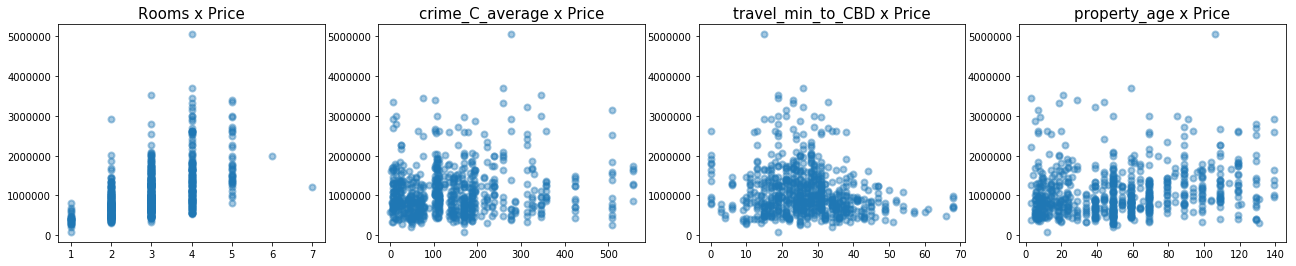

In [89]:
fig, ax = plt.subplots(1,4, figsize = (22,4)) # creating a figure with many subplots

ax[0].scatter( 'Rooms', 'Price', data=data_solution, linewidth=2,  alpha=0.4)
ax[0].set_title('Rooms x Price', fontsize = 15)
ax[1].scatter( 'crime_C_average', 'Price', data=data_solution, linewidth=2,  alpha=0.4)
ax[1].set_title('crime_C_average x Price', fontsize = 15)
ax[2].scatter('travel_min_to_CBD', 'Price', data=data_solution, linewidth=2,  alpha=0.4)
ax[2].set_title('travel_min_to_CBD x Price', fontsize = 15)
ax[3].scatter( 'Age', 'Price', data=data_solution, linewidth=2,  alpha=0.4)
ax[3].set_title('property_age x Price', fontsize = 15)

A first look identies linear relationships between the variables and price, but they are subtle and possibly doing transformations on the data, such as log, power, and root transformation will have as consequence an improvment in this relationships. With respect to Data Normalisation/Scaling methods, we beleive they are not suited for this situation, as they would be for other kinds of models, such as k-means, KNN and PCA. In linear models, only the data distribution is relevant, and shiffiting scale [does not affect the model performance](https://stats.stackexchange.com/questions/32649/some-of-my-predictors-are-on-very-different-scales-do-i-need-to-transform-them) (Macro, 2019).<br>

-----------------------------------
With respects to data transformation **There are many reasons for applying transformation on data:**
1. To generate symmetric distribution instead of the original skewed distribution: Symmetric distribution is usually preferred for modelling and analysis as it is easier to interpret and generate inferences.
2. Transformation helps improving data visualisation of data that might be clustered at the side of the graph. Applying a transformation method will help spreading out the data on the graph for better visualisation.
3. Data is transformed to achieve better interpretability . Relationship between variables are clearer when we re-express the variables, especially when converting non-linear relationship between variables to linear ones.
4. Transformations are often used to improve the compatibility of the data with assumptions underlying a modeling process, to linearise (straighten) the relation between two variables whose relationship is non-linear. Some of data mining algorithms requires the relationship between data to be linear."

-----------------------------------

In this case, we beleive we are dealing with non-linear relationships, and possibly applying root or log will help to linearise the plots. <br>
But before we proceed to any transformation, we will run a simple model that will be used in further steps to see if any transformations will improve R-squared (as a checker).

In [90]:
lm = smf.ols('Price ~ Rooms + crime_C_average + travel_min_to_CBD +  Age', data=data_solution).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     111.0
Date:                Sun, 27 Oct 2019   Prob (F-statistic):           1.28e-72
Time:                        20:59:27   Log-Likelihood:                -9811.9
No. Observations:                 677   AIC:                         1.963e+04
Df Residuals:                     672   BIC:                         1.966e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.544e+05   8.09e+0

Our model has achieved a very low R-squared - of 0.36 and it is no surprise. <br>
As we have stated, we cannot identify clear linear relationships between the variables and price. Something that may be affecting this relationships is the possibility that these variables have not normal distributions.  As we know, when working with linear models we want to be able to capture to interpret our coefficients, and say things like "if I increase my variable X1 by 1, then, on average and all else being equal, [Y should increase by β1.](https://datascience.stackexchange.com/questions/20237/why-do-we-convert-skewed-data-into-a-normal-distribution)" (Cruz, 2017)
Normally distributed data are much better for linear modelling purposes, so we will check now what distribution the data is following.<br>
Let's understand the distribution of our variables by plottig histograms.

Text(0.5, 1.0, 'property_age')

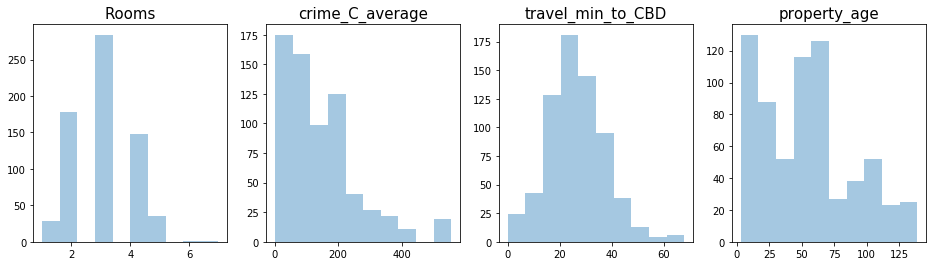

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (16,4)) # creating a figure with many subplots

ax[0].hist('Rooms', data=data_solution, linewidth=2,  alpha=0.4)
ax[0].set_title('Rooms', fontsize = 15)
ax[1].hist( 'crime_C_average', data=data_solution, linewidth=2,  alpha=0.4)
ax[1].set_title('crime_C_average', fontsize = 15)
ax[2].hist('travel_min_to_CBD', data=data_solution, linewidth=2,  alpha=0.4)
ax[2].set_title('travel_min_to_CBD', fontsize = 15)
ax[3].hist( 'Age',data=data_solution, linewidth=2,  alpha=0.4)
ax[3].set_title('property_age', fontsize = 15)

Observations from the histograms:
1. The variables Rooms and travel_min_to_CBD have (almost) normal distributions.<br>
2. The variables crime_c_average and property_age have right skewed distributions.<br>

We have already generated sufficient evidence that our data must be transformed, but specially the columns `crime_c_average` and `property_age`. We will use two different transformation methods to start, log and root. Since we are dealing with skewed data, power transformation would just increase the distortion, so it is out of question to apply it.
Firstly, lets create new columns for this two variables with the respective transformations.

In [92]:
data_solution = data_solution.reset_index(drop = True)

data_solution['root_crime'] = np.nan
data_solution['root_age'] = np.nan
data_solution['log_crime'] = np.nan
data_solution['log_age'] = np.nan
i = 0
for row in data_solution.iterrows():
    data_solution['root_crime'].at[i] = math.sqrt(data_solution['crime_C_average'][i])
    data_solution['root_age'].at[i] = math.sqrt(data_solution['Age'][i])    
    data_solution['log_crime'].at[i] = math.log(data_solution['crime_C_average'][i])
    data_solution['log_age'].at[i] = math.log(data_solution['Age'][i])    
    i += 1

Now, lets plot:
- The histograms of the variables without any transformation.
- The histograms of the variables with log transformation.
- The histograms of the variables with root transformation

Text(0.5, 1.0, 'Root Age')

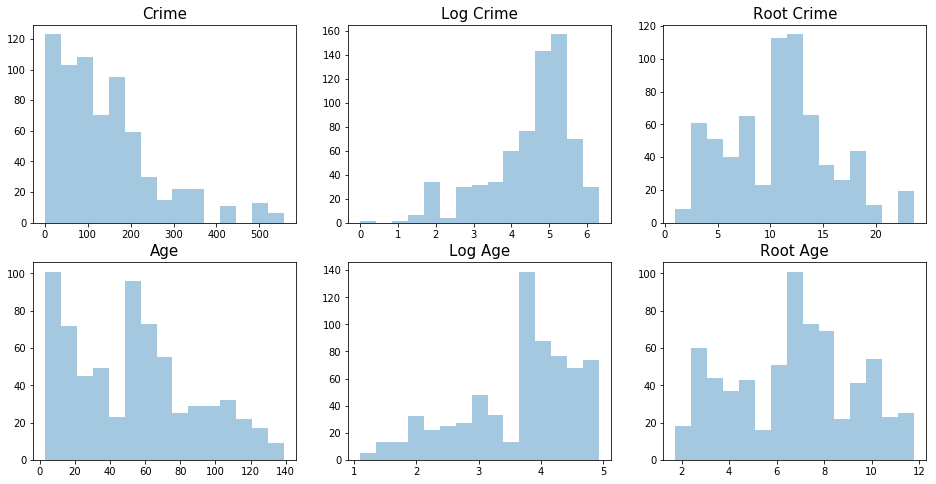

In [93]:
fig, ax = plt.subplots(2,3, figsize = (16,8)) # creating a figure with many subplots

ax[0,0].hist('crime_C_average', data=data_solution, linewidth=2,  alpha=0.4, bins = 15)
ax[0, 0].set_title('Crime', fontsize = 15)
ax[0,1].hist('log_crime', data=data_solution, linewidth=2,  alpha=0.4, bins = 15)
ax[0, 1].set_title('Log Crime', fontsize = 15)
ax[0,2].hist('root_crime', data=data_solution, linewidth=2,  alpha=0.4, bins = 15)
ax[0, 2].set_title('Root Crime', fontsize = 15)
ax[1,0].hist('Age', data=data_solution, linewidth=2,  alpha=0.4, bins = 15)
ax[1, 0].set_title('Age', fontsize = 15)
ax[1,1].hist('log_age', data=data_solution, linewidth=2,  alpha=0.4, bins = 15)
ax[1, 1].set_title('Log Age', fontsize = 15)
ax[1,2].hist('root_age', data=data_solution, linewidth=2,  alpha=0.4, bins = 15)
ax[1, 2].set_title('Root Age', fontsize = 15)


This plots demonstrate with clarity that the data becomes more normally-shaped with our transformations. To continue this comparation we will again plot the scatter plots, to check if we have genarated more linear relations. We will plot:
1. The regular plots without any transformation
2. The plots with the log transformation in the variables.
3. Log-log plots - that means with log transformation also in the predicted variable, the proce.

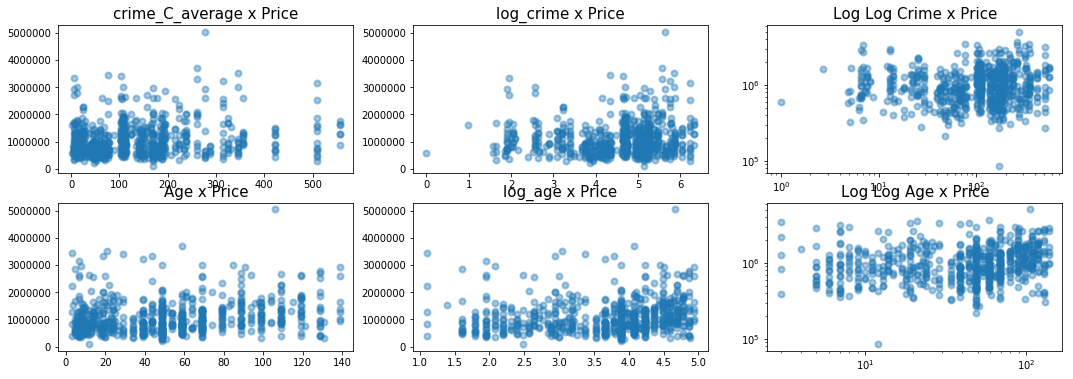

In [94]:
fig, ax = plt.subplots(2,3, figsize = (18,6)) # creating a figure with many subplots

ax[0,0].scatter('crime_C_average', 'Price', data=data_solution, linewidth=2,  alpha=0.4)
ax[0,0].set_title('crime_C_average x Price', fontsize = 15)
ax[0,1].scatter('log_crime', 'Price', data=data_solution, linewidth=2,  alpha=0.4)
ax[0,1].set_title('log_crime x Price', fontsize = 15)
ax[0,2].scatter('crime_C_average', 'Price', data=data_solution, linewidth=2,  alpha=0.4)
ax[0,2].set_title('Log Log Crime x Price', fontsize = 15)
ax[0,2].set_yscale('log')
ax[0,2].set_xscale('log')
ax[1,0].scatter('Age', 'Price', data=data_solution, linewidth=2,  alpha=0.4)
ax[1,0].set_title('Age x Price', fontsize = 15)
ax[1,1].scatter('log_age', 'Price', data=data_solution, linewidth=2,  alpha=0.4)
ax[1,1].set_title('log_age x Price', fontsize = 15)
ax[1,2].scatter('Age', 'Price', data=data_solution, linewidth=2,  alpha=0.4)
ax[1,2].set_title('Log Log Age x Price', fontsize = 15)
ax[1,2].set_yscale('log')
ax[1,2].set_xscale('log')


We believe to have generated an improvment in the linear relation with this transformations, now we will check with respect to models if the R-squared will show any improvment. 

In [95]:
lm_log = smf.ols('Price ~ Rooms + np.log(crime_C_average) + travel_min_to_CBD + np.log(Age)', data=data_solution).fit()
lm_loglog = smf.ols('np.log(Price) ~ np.log(Rooms) + np.log(crime_C_average) + travel_min_to_CBD + np.log(Age)', data=data_solution).fit()

print("Base Model R-squared", lm.rsquared)
print("Log Model R-squared", lm_log.rsquared)
print("Log Log Model R-squared", lm_loglog.rsquared)

Base Model R-squared 0.3978670622079744
Log Model R-squared 0.3834424651375363
Log Log Model R-squared 0.47358964255626024


We have achieved a significant improvment in our model by applying log transformations in all variables, including the predicted variable price, with exception of `travel_min_to_CBD` that already had a normal distribution and good linear relationship with price.

# 6. Summary
This assessment measured the understanding of data integration and reshaping techniques in the Python programming language. The main outcomes achieved while applying these techniques were:

- **Shapefiles**. Extracting information from shapefiles with geopandas was quite new for us. We learned not only to use geapandas, but also to handle polygons and find regions inside its boundaries. It was necessary to do it in order to retrieve the suburbs, given its latitude/longitude.
- **Web-scrapping**. Getting the school ranks from webpages had a lot of steps involved, including extracting data from the web and working on it with BeautifulSoup and pandas until we have the data organized in a proper dataframe.
- **Work with gtfs Data**. Working with gtfs data can be quite challening. As we have demonstrated, it is as sofisticated format, requiring a deep understanding of its database schema. Using the functions join and concatenate, we were able to generate a big table/dataframe with all the necessary information, and after a succession of filtering steps we could find the wanted train stations, average time of trips, etc.
- **Data Transformation**. With the aim to improve a linear model between the variables Rooms, crime_C_average, travel_min_to_CBD , and property_age(predictors) and price(predicted) we performed an analysis of the statistical distribution of these variables and their relatioship against the price. After it was stablished what could be improved, transformations were performed in some of the variables, such as root and log transformation. At the end, only to confirm the success of this transformations, we checked the R-squared of the model that presented an relevant increase.

## References

- Crime Statistics Agency (2019). *Offence classification
*. Retrieved from https://www.crimestatistics.vic.gov.au/about-the-dataclassifications-and-victorian-map-boundaries/offence-classification

- Cruz, R. (2017, July 14). *Why do we convert skewed data into a normal distribution* [Response to]. Retrieved from 
https://datascience.stackexchange.com/questions/20237/why-do-we-convert-skewed-data-into-a-normal-distribution

- Gordon, A. (December 10, 2018). *Working with Open Data shape files using Geopandas — how to match up your data with the areas defined in the shape file*. Retrieved from
https://medium.com/dataexplorations/working-with-open-data-shape-files-using-geopandas-how-to-match-up-your-data-with-the-areas-9377471e49f2 

-  Jovanovik Milos (April, 2014) *Open Public Transport Data in Macedonia*. Retrieved from
https://www.researchgate.net/figure/The-GTFS-Schema-for-the-data-from-JSP-Skopje_fig1_263853949

-  Jovanovik Milos (March, 2015) *PTV - GTFS Release Notes*. Retrieved from
http://data.ptv.vic.gov.au/downloads/PTVGTFSReleaseNotes.pdf

- Macro (2012, July 19). *Some of my predictors are on very different scales - do I need to transform them before fitting a linear regression model?* [Response to]. Retrieved from 
https://stats.stackexchange.com/questions/32649/some-of-my-predictors-are-on-very-different-scales-do-i-need-to-transform-them

- manjeet_04, GeeksForGeeks (2019). *Python | Position Summation in List of Tuples
*. Retrieved from https://www.geeksforgeeks.org/python-position-summation-in-list-of-tuples/

- Masango, S. (2018, July 27). *Web Scraping using Python*. Retrieved from https://www.datacamp.com/community/tutorials/web-scraping-using-python

- Preste R. (2019, May 29). *From XML to Pandas dataframes*. Retrieved from https://medium.com/@robertopreste/from-xml-to-pandas-dataframes-9292980b1c1c

- Python Software Foundation. (2019a). ElementTree *The ElementTree XML API*. Retrieved from https://docs.python.org/3/library/xml.etree.elementtree.html

- Python Software Foundation. (2019b). difflib *get_close_matches*. Retrieved from https://docs.python.org/3/library/difflib.html#difflib.get_close_matches

- Rocha, B. (2012, Jun 7). *Haversine formula example in Python*. Retrieved from https://gist.github.com/rochacbruno/2883505

- School Catchment (2019, November 27) *Top 500 Ranking Victoria Melbourne Primary School For The Year Of 2018 (Government and Non-government)*. Retrieved from http://www.schoolcatchment.com.au/?p=12301

- Statistics Solutions (2019). *Assumptions of Linear Regression*. Retrieved from:
https://www.statisticssolutions.com/assumptions-of-linear-regression/

- The `pandas` Project. (2019a). *pandas 0.25.2 documentation: Concatenating objects
*. Retrieved from https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#concatenating-objects

- The `pandas` Project. (2019b). *pandas 0.25.2 documentation: Reshaping and pivot tables
*. Retrieved from https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html

- The `pandas` Project. (2019c). *pandas 0.25.2 documentation: Database-style DataFrame or named Series joining/merging*. Retrieved from https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#database-style-dataframe-or-named-series-joining-merging